# Interpretable Insights in Healthcare: Explaining Model Decisions in Image and Tabular Data Analysis with SHAP 

### 1. Background and Relevance

Over the past few years, deep learning and machine learning models have generated considerable interest in critical areas such as healthcare, finance, criminal justice, etc. However, the lack of explainability of such models is generally considered a major barrier to adopting automated AI-based decision-making processes (Chander et al., 2018).

As a result, there is a growing demand for transparency and accountability in the decision-making processes of such systems in these critical domains. Particularly in the medical field, explainable AI plays a pivotal role in assisting medical practitioners and healthcare professionals to make decisions that are explainable, transparent, understandable, and accountable (Holzinger et al.,2017). Considering that such decisions significantly impact the further treatment process and, thus, in some cases, also on the patient's well-being, explainability becomes even more critical when severe misclassifications occur.

#### Image Data

Doctors often manually examine thousands of images from a single medical procedure in conventional imaging diagnostics. This process is incredibly time-consuming and relies on the doctor’s prolonged attention. However, by employing deep learning and techniques for AI-based extraction of information from images, this process can be significantly streamlined to become much faster, more convenient, and more resource-efficient. After all, the transparent and explainable decisions or results generated by such a model would only need to be validated by a doctor (Meske & Bunde, 2020; Knapič et al., 2021).

#### Tabular Data

Despite their accuracy and speed, AI systems often lack transparency in their decision-making processes, posing risks, especially in healthcare. Therefore, building explainable AI is crucial. Since heart disease is one of the leading causes of death globally, developing AI models that can predict heart disease while providing clear explanations for their decisions is vital (Dave et al., 2020).
 
Recent legal trends also emphasize transparency requirements for information systems to mitigate unintended adverse effects in decision-making processes. In particular the European Union introduced the General Data Protection Regulation (GDPR) grants users the right to be informed about machine-generated decisions that affect them (Voigt & Von Dem Bussche, 2017). Consequently, patients affected by decisions made by a machine learning model may seek to understand the reasons for the decisions and outcomes that such a system has arrived at (Knapič et al., 2021b).

### 1.2 This Project

To address this issue we will utilize SHAP (Shapley Additive exPlanations ), to explain complex model decisions and answer the following research questions:

**RQ1:** What are the key differences in the interpretability of machine learning models between image classification and tabular data analysis when utilizing SHAP explanations?

**RQ2**: How does SHAP reveal the importance of different regions or structures within MRI brain scans in the decision-making process of machine learning models for brain tumor detection?

**RQ3**: How does SHAP analysis reveal the importance of various clinical and demographic features in the prediction of heart failure using a machine learning model?

#### 1.2.1 Data

**MRI Brain Scans:** The dataset contains MRI Brain scans, the goal of which is to classify 4 types of tumors/no-tumor (Brain Tumor MRI Dataset, 2021).

**Heart Failure:**: In this dataset, 5 heart datasets are combined over 11 common features, making it the largest heart disease dataset available so far for research purposes (Heart Failure Prediction Dataset, 2021).

#### 1.2.2 Methods

**Transfer Learning:**
Transfer learning is a machine learning method where a model developed for one task is reused as the starting point for a model on a second task, offering advantages such as reduced computational costs, smaller necessary dataset sizes, and enhanced model generalizability (Murel Jacob & Kavlakoglu, 2024). 

Several types of transfer learning have been proposed for medical imaging data and have been very effective, such as AlexNet, SPP-Net, VGGNet, ResNet, GoogLeNet, etc., with these models, including ResNet, demonstrating promising outcomes in the analysis of medical images (Salehi et al., 2023).
For our project, we will utilize the ResNet50 architecture from TensorFlow, adapt it, and retrain it on MRI Brain scans.

**Tabular Data - Neural Network:**

For the tabular data, a simple artificial neural net will be built and trained using TensorFlow for binary classification.

**SHAP:** 

SHAP is an explainable AI tool that provides a unified framework for interpreting the output of any machine learning model. It quantifies the contribution of each feature to a model’s prediction, allowing for better understanding and transparency (SHAP, n.d.)
We will utilize SHAP to provide explanations for both datasets.


## 2. MRI Brain Scans

In this part of our analysis, we will classify and interpret different types of brain tumors. This is divided into 3 main parts:

**Multi-Class Classification:** We first train a model to classify MRI scans into four categories: glioma, meningioma, pituitary, and no tumor. We then utilize SHAP explanations to identify which regions of the brain are most relevant for distinguishing between these classes.

**Binary Classification:** We train a separate model to distinguish between meningioma and no tumor. This model helps us understand how the classification task changes when reduced to a binary problem and allows us to compare the SHAP explanations with the multi-class model.

**Three-Class Classification:** Lastly, we train a model to classify only the tumor types (glioma, meningioma, and pituitary tumor), excluding the no-tumor class. This approach helps us investigate if the SHAP explanations differ when focusing solely on different tumor types.

### 2.1 Multi-Class Classification

Prerequisits: import all of the relevant libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50

Setting current working directory where the MRI Brain scans have been stored in the folders Training and Testing

In [2]:

cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: C:\Users\marku\Documents\UNI\Semester_4\AI_2


In [3]:
path_dir_tr = "C:insert_your_path\\tumor\\Training"
path_dir_te = "C:insert_your_path\\tumor\\Testing"

#### 2.1.1 Loading and Preprocessing the MRI Brain Scnas

The first step invloves building the dataset for classifying different types of brain tumors from MRI scans.
The 4 categories are: **glioma, meningioma, notumor and pituitary.**

The dataset comprises MRI images stored in corresponding folders for each category. In this notebook, we will read these images, preprocess them, and label them based on their folder names. Additionally, we will transform the images into a format suitable for training with the ResNet50 architecture.

The training and test data has already been seperated in the folders. Therefore, we will load train and test data separetly from the respective directories.

In [4]:
# Define the categories for classification
Categories = ["glioma","meningioma","notumor","pituitary"]

#### 2.1.2 Data Pre-processing

#### 2.1.2.1 Train Data


As a first step, the training data will be loadeded from the specified directory

In [5]:
data = []
#This function reads MRI brain scan images from specified directories, resizes them, and stores
#them along with their corresponding class labels in the 'data' list.
def create_data():
    for categories in Categories:
        path = os.path.join(path_dir_tr , categories)
        class_name = categories
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path,img))
                # Resize the images to 100x100 pixels
                new_array = cv.resize(img_array , (100,100))
                data.append([new_array , class_name])
            except Exception as e:
                pass
create_data()

For more efficient training we will reshuffle the training data and set a seed for better reproducability

In [6]:
seed_value = 777
np.random.seed(seed_value)

np.random.shuffle(data)

In [7]:
# Initialize empty lists to store features (images) and labels
x_data = []
y_data = []
# Iterate through the data and separate features and labels
for features,labels in data:
    x_data.append(features)
    y_data.append(labels)

In [8]:
y_data[1:10]

['notumor',
 'notumor',
 'notumor',
 'meningioma',
 'pituitary',
 'glioma',
 'pituitary',
 'notumor',
 'glioma']

In [9]:
df = pd.DataFrame(y_data,columns=["labels"])

In [10]:
df.head()

labels
0     notumor
1     notumor
2     notumor
3     notumor
4  meningioma

Before training our model, it's important to understand the distribution of our dataset. We'll visualize how many samples we have for each category of brain tumors using a count plot. 

<Axes: xlabel='labels', ylabel='count'>

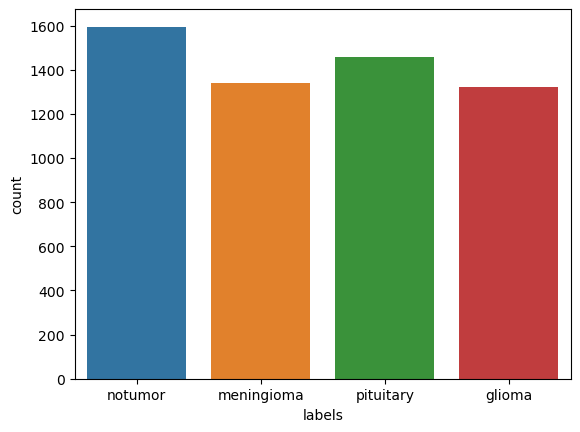

In [11]:
sns.countplot(x='labels', data=df)

From the count plot, we can see that the dataset is quite balanced across the different categories. 
Next, we will transform the data into a NumPy array and encode the labels to prepare for model training.

In [12]:
x_data = np.array(x_data)

In [13]:
## mapping to integers
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
## applying mapping on the targets
y_data = np.array([label_mapping[label] for label in y_data])

y_data

array([3, 3, 3, ..., 1, 3, 3])

In [14]:
y_data[421]

1

Looking at an MRI scan which shows meningioma tumor.

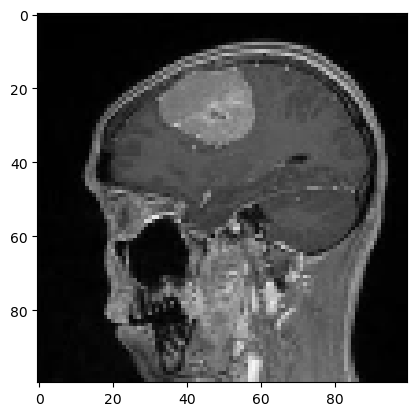

In [15]:
plt.imshow(x_data[421])

#### 2.1.2.2 Train Data
The same data loading and pre-processing steps will be done for the test data

In [16]:
test_data = []
#This function reads MRI brain scan images from specified directories, resizes them, and stores
#them along with their corresponding class labels in the 'data' list.
def create_data():
    for categories in Categories:
        path = os.path.join(path_dir_te , categories)
        class_name = categories
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path,img))
                # Resize the images to 100x100 pixels
                new_array = cv.resize(img_array , (100,100))
                test_data.append([new_array , class_name])
            except Exception as e:
                pass
create_data()

In [17]:
test_data[0]

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'glioma']

In [18]:
random.shuffle(test_data)

In [19]:
x_test = []
y_test = []
for features,labels in test_data:
    x_test.append(features)
    y_test.append(labels)

In [20]:
x_test = np.array(x_test)

In [21]:
y_test[38]

'pituitary'

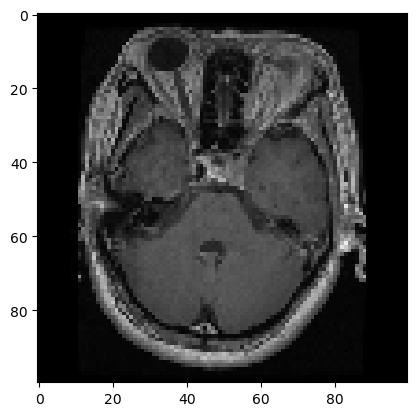

In [22]:
plt.imshow(x_test[38])

In [23]:
## applying the same mapping for the test set

y_test = np.array([label_mapping[label] for label in y_test])

### 2.1.3 Transfer Learning / Model Training

In this section, we will utilize the ResNet50 architecture, a powerful convolutional neural network that has been pre-trained on the ImageNet (more than 14 million images) dataset. Transfer learning allows us to leverage this pre-trained model and architecture and retrain it on the MRI brain scans.

Before starting we will check if the test and train set have the required shape.

In [24]:
x_data.shape

(5712, 100, 100, 3)

In [25]:

x_test.shape

(1311, 100, 100, 3)

In [26]:
seed_value = 777
tf.random.set_seed(seed_value)

# Define the model architecture using Sequential 
model = Sequential()
# Add ResNet50 as a base model (excluding the top layer)
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                       weights=None, # weights will be retrained (weights = "imagenet" would use the pretrained weights)
                                       input_shape=(100,100,3),
                                       classes=4)

model.add(resnet)
# Flatten the output of ResNet50
model.add(Flatten())
# Add a fully connected layer with 122 neurons and ReLU activation
model.add(Dense(122,activation="relu"))
# Add the output layer with 4 neurons for 4 classes and softmax activation
model.add(Dense(4,activation="softmax"))

In [27]:
seed_value = 777
# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

To save computation time for further processing, we will save our best performing model based on the validation accuracy in a keras file.

In [27]:
seed_value = 777
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model_all_test.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
history = model.fit(x_data, y_data, validation_data=(x_test, y_test), epochs=20, batch_size=100, callbacks=[checkpoint])

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3633 - loss: 7.0578
Epoch 1: val_accuracy improved from -inf to 0.30511, saving model to best_model_all.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.3645 - loss: 6.9879 - val_accuracy: 0.3051 - val_loss: 4299.3125
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6762 - loss: 0.8118
Epoch 2: val_accuracy did not improve from 0.30511
58/58 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.6772 - loss: 0.8099 - val_accuracy: 0.2601 - val_loss: 1.6125
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8412 - loss: 0.4351
Epoch 3: val_accuracy did not improve from 0.30511
58/58 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.8416 - loss: 0.4342 - val_accuracy: 0.2632 - val_loss: 2.0032
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8978 - loss: 0.2792
Epoch 4: val_accuracy improved from 0.30511 to 0.54310, saving model to best_model_all.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 263s 

In [28]:
# Load the best model 
#best_model_all = tf.keras.models.load_model('best_model_all.keras')

In [29]:
# Compile the model 
best_model_all.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Evaluate the model on the validation set
val_loss, val_accuracy = best_model_all.evaluate(x_test, y_test)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9155 - loss: 0.2578
Validation Accuracy: 92.22%


Our best performing model as achieved a **validation accuracy** on the test set of **92%.**

Generating the confusion matrix.

179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 274ms/step


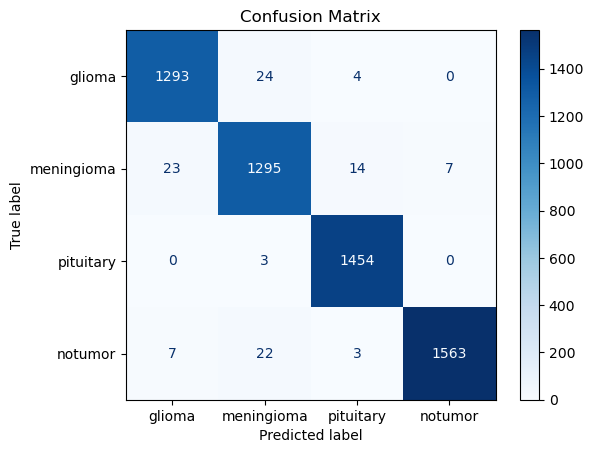

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# best_model_all.predict returns probabilities for each class
predictions = best_model_all.predict(x_data)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_data, predicted_classes)

# Define class names 
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues') 
plt.title('Confusion Matrix')
plt.show()

In the context of detecting tumors, the most important measure is not accuracy but avoiding false negatives in the class no tumor.
The false negatives in the class no tumor are only **0,44%**, but this is still problematic in a real-life scenario. Seven brain scans of the class meningioma have been wrongly labeled as no tumor.

### 2.1.4 SHAP Analysis

After training the model the next part will be to develop SHAP explanations.
We will create SHAP explanations for all 4 classes.

In [31]:
# reverse mapping to get the description instead of the Integers
label_rev_mapping = { 0: 'glioma', 1 : 'meningioma', 2 : 'pituitary' , 3 : 'notumor'}

y_decoded = np.array([label_rev_mapping[label] for label in y_data])

In [32]:
y_decoded

array(['notumor', 'notumor', 'notumor', ..., 'meningioma', 'notumor',
       'notumor'], dtype='<U10')

In [33]:
# Masks out image regions with blurring or inpainting.
masker = shap.maskers.Image("inpaint_telea", x_data[0].shape)

In [34]:
# class names the predictions
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 

In [35]:
# Uses Shapley values to explain the trained model
explainer = shap.Explainer(best_model_all, masker, output_names=class_names)

Note: outputs=shap.Explanation.argsort.flip[:3] will be used in the code for getting SHAP values because we want to get the top 3 most probable classes for each image i.e. top 3 classes with decreasing probability.

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.80s/it]               


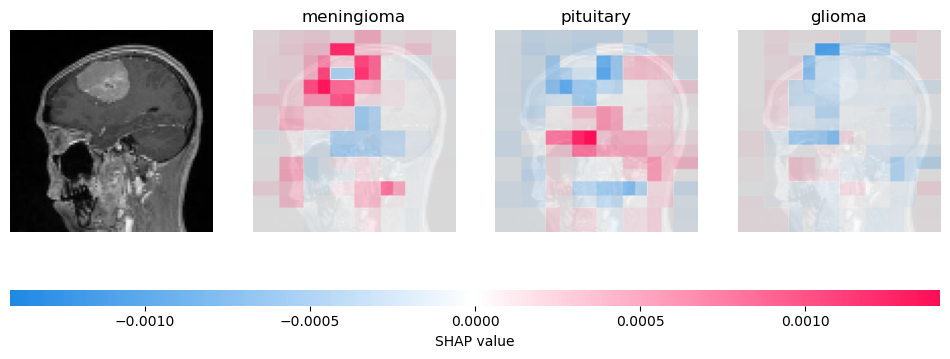

In [36]:
shap_values = explainer(
    x_data[421:422], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

The predictions for our first test image are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values that reduce the probability of the class.

The correct label:

In [41]:
y_decoded[421]

'meningioma'

The picture with the most red pixels is also the correct label. The red pixels are also quite clustered around the tumor which shows that the SHAP explanations work very well for this image.

We check if the model makes the correct predictions for the image used in SHAP to ensure the explanations are meaningful and accurate. This verification step confirms that our SHAP analysis highlights the most relevant brain regions for correctly classified images.

In [37]:
# Select the image from x_data
test_image = x_data[421]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: meningioma


The model made the **correct prediction!**

  0%|          | 0/1998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.75s/it]               


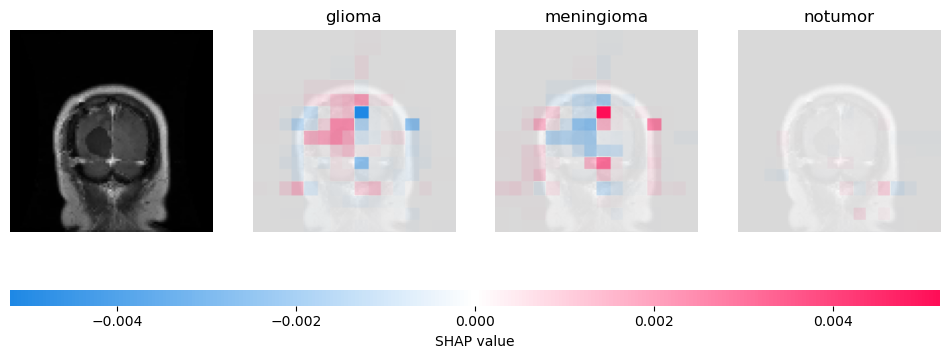

In [38]:
shap_values = explainer(
    x_data[623:624], max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3] 
)
shap.image_plot(shap_values)

In this plot above a glioma tumor has been sucessfully predicted, the red pixels are also quite close to the tumor in the brain scan.

In [39]:
y_decoded[623]

'glioma'

In [40]:
# Select the image from x_data
test_image = x_data[623]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class: glioma


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]               


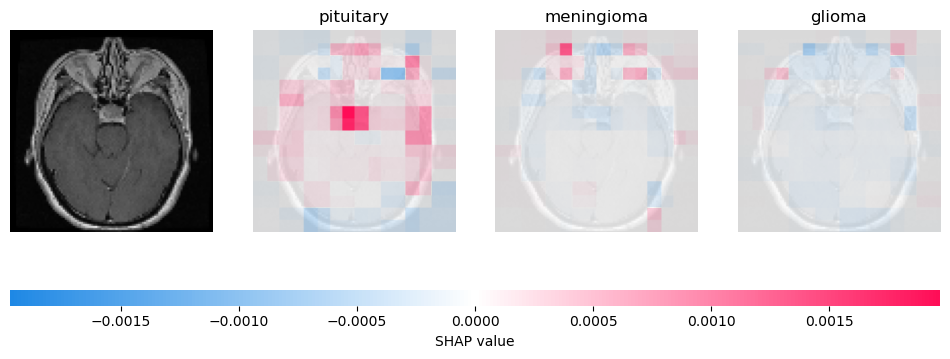

In [45]:
shap_values = explainer(
    x_data[110:111], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

The shap explanations also work very well for the third type of tumor (pituitary) - the pixels in red a very strong and clustered.

In [46]:
y_decoded[110]

'pituitary'

In [47]:
# Select the image from x_data
test_image = x_data[110]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: pituitary


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.04s/it]               


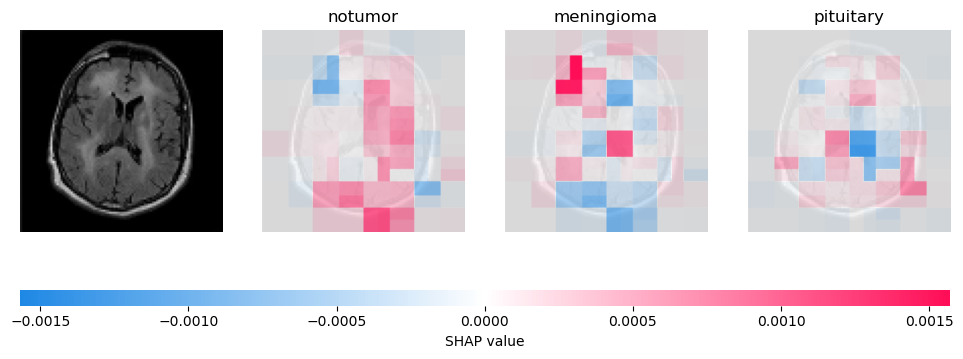

In [48]:
shap_values = explainer(
    x_data[3:4], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

This test image shows a brain scan with notumor - the red pixels are not as clustered as with the tumor brain scans and highlight healthy regions of the brain. The model also strongly highlights an area outside of the scan as no tumor.

In [49]:
y_decoded[3]

'notumor'

In [50]:
# Select the image from x_data
test_image = x_data[3]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: notumor


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [01:02<00:15, 15.85s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:34<00:00, 22.47s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [02:03, 31.00s/it]                       


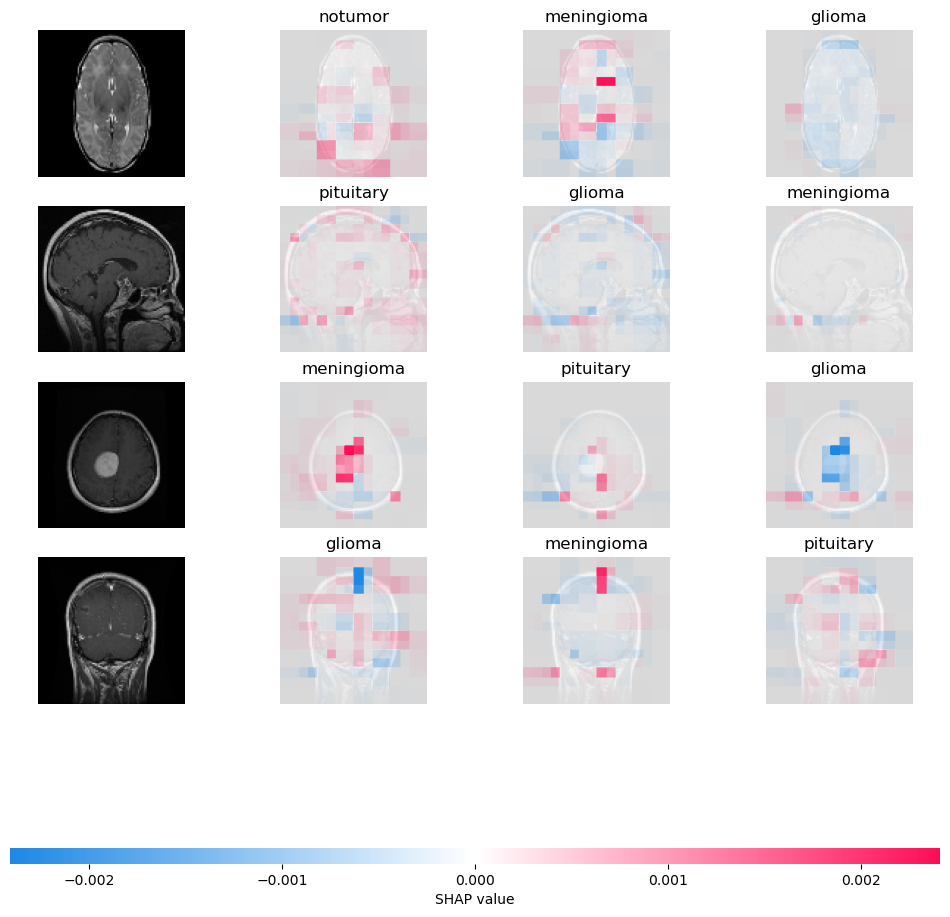

In [54]:
shap_values = explainer(
    x_data[207:211], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

The MRI images in this dataset come from different perspectives, which means that the orientation and angle of the scans can vary significantly. This variability introduces an additional layer of complexity to the classification task, as the model needs to be robust enough to handle these differences in image perspectives. Nevertheless, the model and the SHAP explanations already showed that it is very robust and can MRI scans from different angles.

In [55]:
y_decoded[207:211]

array(['notumor', 'pituitary', 'meningioma', 'glioma'], dtype='<U10')

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:00, 30.01s/it]               


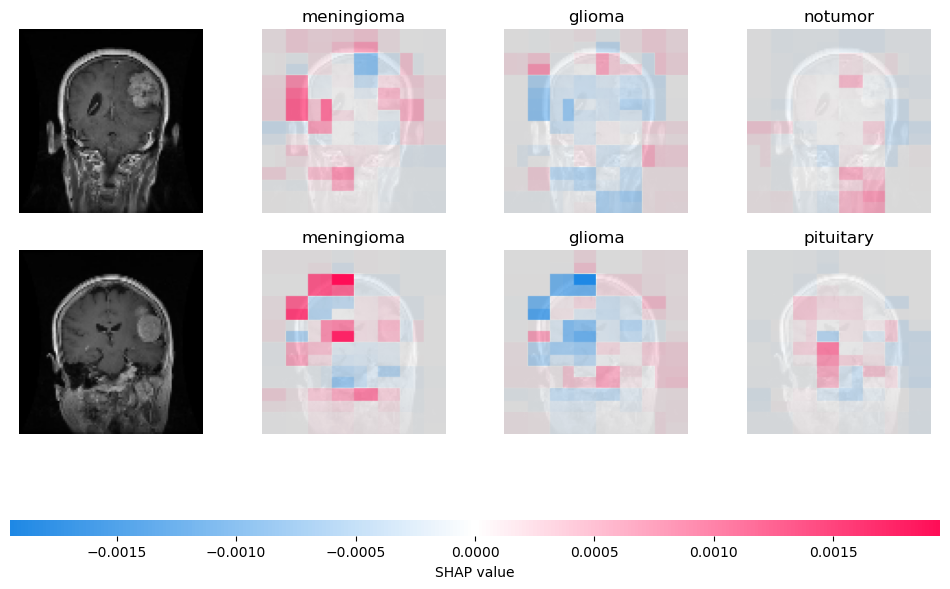

In [85]:
shap_values = explainer(
    x_data[1014:1016], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

Although the model correctly predicts the presence of the correct tumors in these examples, the SHAP image explanations highlight pixels that do not correspond to the actual location of the tumor. This indicates that while the model performs well, it might be learning patterns that allow it to classify images correctly without accurately identifying the relevant regions in the brain scans. This underscores the necessity of improving the model and maintaining human surveillance in a real-world scenario. SHAP is very powerful in revealing these discrepancies and helps to understand the model's decision-making process. This can be used as a basis to understand how the model's decision-making process aligns with medical expertise.

In [44]:
#correct labels
y_decoded[1014:1016]

array(['meningioma', 'meningioma'], dtype='<U10')

In [50]:
# Select the image from x_data
test_image = x_data[1014]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: meningioma


As a final step, we examine an example where the model predicted "notumor" (class 3) but the actual diagnosis was "meningioma" (class 1). This scenario represents a critical error in real-life applications, as failing to detect a tumor can have severe consequences.

179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step
Example where the model predicted class 1 but the actual class was 3: Index 1031


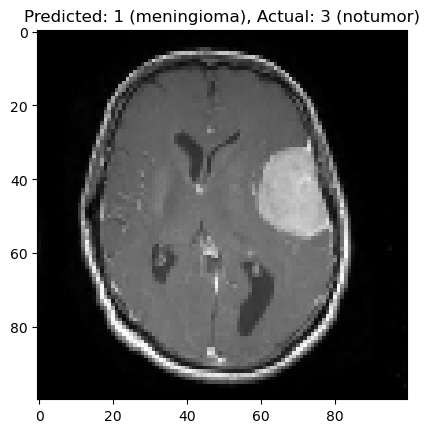

In [48]:
# Generate predictions
predictions = best_model_all.predict(x_data)
predicted_classes = np.argmax(predictions, axis=1)

# Find examples where the model predicted class 3 but the actual class was 1
mismatch_indexes = [
    i for i, (true_label, predicted_label) in enumerate(zip(y_data, predicted_classes))
    if predicted_label == 3 and true_label == 1
]

# Print the index of the first example
example_index = mismatch_indexes[0]
print(f"Example where the model predicted notumor but the actual class was meningioma: Index {example_index}")

# Display the example image
example_image = x_data[example_index]
plt.imshow(example_image, cmap='gray')
plt.title(f"Predicted: 1 (meningioma), Actual: 3 (notumor)")
plt.show()

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.78s/it]               


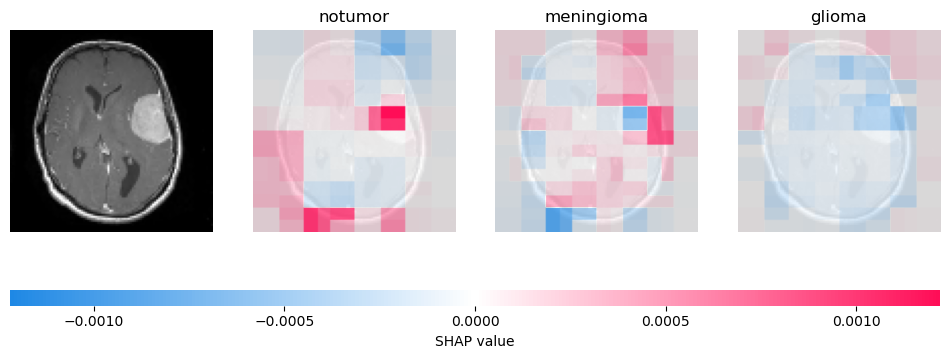

In [49]:
shap_values = explainer(
    x_data[1031:1032], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

The SHAP explanations show that even though the red pixels are densely clustered around the region of interest (the tumor), the model still predicted "notumor". Interestingly, the second most likely class, which is the correct class, "meningioma" (class 1), also shows some red pixels around the tumor region. This highlights a crucial challenge in identifying tumors in MRI scans, which are black-and-white images. The model may also sometimes learn patterns from areas outside the actual image, which are uniformly black.

In [52]:
y_decoded[1031]

'meningioma'

In [53]:
# Select the image from x_data
test_image = x_data[1031]

# Reshape the image to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Get the model's prediction
prediction = best_model_all.predict(test_image)
# Decode the prediction
predicted_class = np.argmax(prediction, axis=1)

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor'] 
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: notumor


### 2.2 Binary Classification (No Tumor or Meningioma) 

Our model, trained to classify 4 different types of brain tumors, has already achieved an **accuracy of 92%**.

Building upon this, we now aim to refine our approach by focusing specifically on distinguishing between one specific tumor (meningioma) and no tumor cases. By retraining the ResNet50 architecture on this subset of data, we seek to further enhance the model's accuracy and efficiency in this binary classification task.

Therefore, we first need to remove the data from the other classes.

####  2.2.1 Data Preprocessing

In [45]:
# Define the labels to keep
labels_to_keep = ['meningioma', 'notumor']

# Create a mask to filter the data
mask = np.isin(y_decoded, labels_to_keep)

# Apply the mask to filter the data
x_data_filtered = x_data[mask]
y_data_filtered = y_data[mask]

In [46]:
y_data_filtered

array([3, 3, 3, ..., 1, 3, 3])

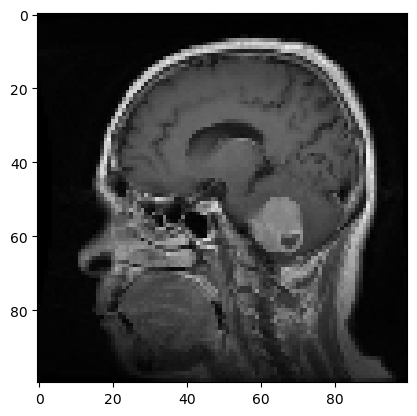

In [47]:
plt.imshow(x_data_filtered[96])

We also need to decode the test set and get the labels.

In [48]:
# reverse mapping to get the description instead of the Integers
label_rev_mapping = { 0: 'glioma', 1 : 'meningioma', 2 : 'pituitary' , 3 : 'notumor'}

y_test_decoded = np.array([label_rev_mapping[label] for label in y_test])

In [49]:
y_test_decoded

array(['notumor', 'glioma', 'pituitary', ..., 'glioma', 'notumor',
       'notumor'], dtype='<U10')

In [50]:
# Create a mask to filter the test data
mask_test = np.isin(y_test_decoded, labels_to_keep)

# Apply the mask to filter the test data
x_test_filtered = x_test[mask_test]
y_test_filtered = y_test[mask_test]


Mapping the data to 0 for notumor and 1 for meningioma.

In [51]:
#previous mapping: label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}

##new mapping: 
label_mapping2 = {1: 1, 3: 0}

##train
y_data_filtered = np.array([label_mapping2[label] for label in y_data_filtered])

##test
y_test_filtered = np.array([label_mapping2[label] for label in y_test_filtered])

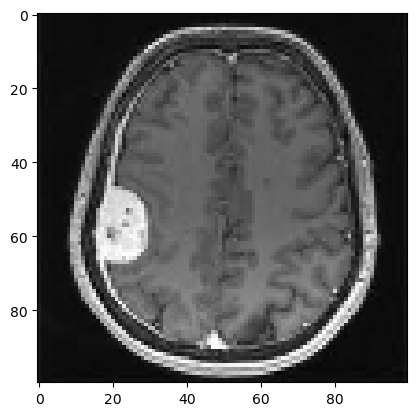

In [103]:
plt.imshow(x_test_filtered[4])

<Axes: xlabel='labels', ylabel='count'>

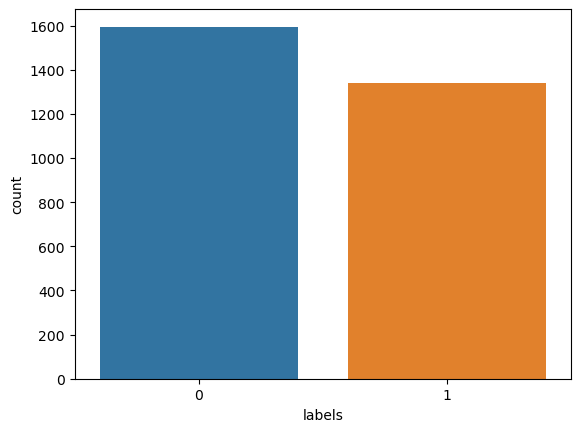

In [104]:
train_df = pd.DataFrame(y_data_filtered, columns=["labels"])
sns.countplot(x='labels', data=train_df)

In [52]:
from tensorflow.keras.utils import to_categorical

# One-hot encode y_data_filtered and y_test_filtered
y_data_filtered_one_hot = to_categorical(y_data_filtered, num_classes=2)
y_test_filtered_one_hot = to_categorical(y_test_filtered, num_classes=2)

#### 2.2.2 Training the second model with the adapted architecture

In [431]:
seed_value = 41
tf.random.set_seed(seed_value)

model2 = Sequential()
resnet2 = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                       weights=None,
                                       input_shape=(100,100,3),
                                       classes=2)
model2.add(resnet2)
model2.add(Flatten())
model2.add(Dense(122,activation="relu"))
model2.add(Dense(2, activation='softmax'))  # Output layer adjusted for 2 classes

In [432]:
seed_value = 41
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [433]:
seed_value = 41
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint2 = ModelCheckpoint('best_model2_test.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
history2 = model2.fit(x_data_filtered, y_data_filtered_one_hot, validation_data=(x_test_filtered, y_test_filtered_one_hot), epochs=20, batch_size=100, callbacks=[checkpoint2])

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5379 - loss: 6.7222
Epoch 1: val_accuracy improved from -inf to 0.56962, saving model to best_model2.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - accuracy: 0.5379 - loss: 6.6075 - val_accuracy: 0.5696 - val_loss: 25097782.0000
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5488 - loss: 0.6399
Epoch 2: val_accuracy did not improve from 0.56962
30/30 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.5486 - loss: 0.6396 - val_accuracy: 0.5696 - val_loss: 24849.8457
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5488 - loss: 0.6281
Epoch 3: val_accuracy did not improve from 0.56962
30/30 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.5486 - loss: 0.6275 - val_accuracy: 0.5696 - val_loss: 309.0490
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6478 - loss: 0.5553
Epoch 4: val_accuracy improved from 0.56962 to 0.64557, saving model to best_model2.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1

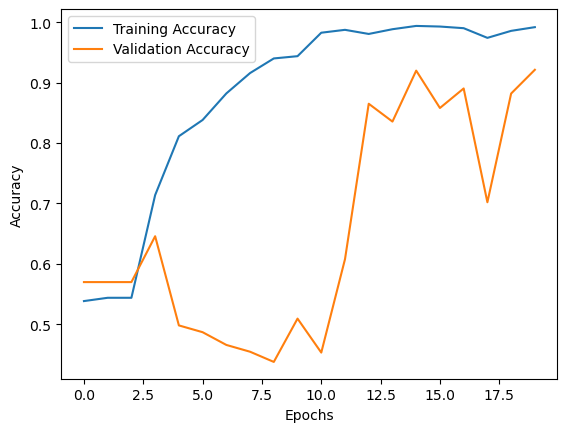

In [438]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the first 10 epochs, the model showed strong signs of overfitting as the training accuracy consistently outperformed the test accuracy. However, as training progressed, the model's performance on the training and test sets got closer.

In [2]:
# loading the trained model
#best_model2 = tf.keras.models.load_model('best_model2.keras')

In [53]:
# Compile the model 
best_model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Evaluate the model on the validation set
val_loss, val_accuracy = best_model2.evaluate(x_test_filtered, y_test_filtered)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9209 - loss: 0.4258
Validation Accuracy: 92.12%


The "best_model_2" that achieved an **accuracy of ~92%** in classifying between notumor and meningioma.

#### 2.2.3 SHAP Analysis

In [54]:
# reverse mapping to get the description instead of the Integers
class_names = ['notumor', 'meningioma']

In [55]:
masker = shap.maskers.Image("inpaint_telea", x_data_filtered[0].shape)

In [56]:
explainer = shap.Explainer(best_model2, masker, output_names= class_names)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.04s/it]               


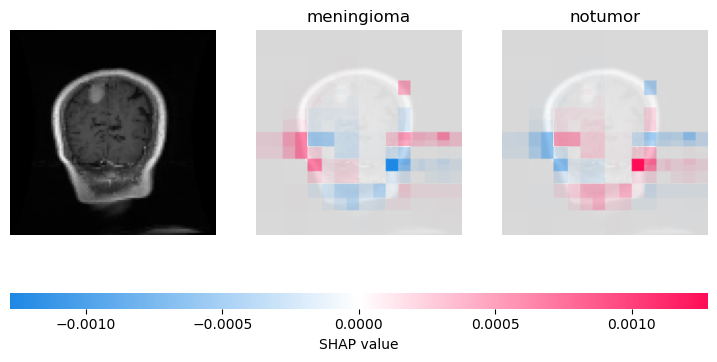

In [58]:
shap_values = explainer(
    x_data_filtered[2063:2064], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2]
)
shap.image_plot(shap_values)

The model performs well in terms of prediction accuracy in the binary classification task (meningioma or notumor). However, the SHAP explanations do not provide as clear insights as they did for the multi-class classification. For binary classification, the SHAP explanations consistently showed opposite pixel contributions for each class, with red pixels in one class appearing as blue in the other. This mirroring effect does not reveal as much information as it does in multi-class settings.

Additionally, the highlighted pixels in the SHAP explanations are not clustered around the correct region of the brain. Therefore, in our example, SHAP did not work as well for binary classification, highlighting the necessity of further refinement in interpretability methods for binary medical image classification.

In [134]:
y_data_filtered[2063]

1

In [136]:
# Select the images from x_data
test_images = x_data_filtered[2063]

# Reshape the images to match the input shape expected by the model
test_images = np.expand_dims(test_images, axis=0)

# Get the model's predictions
predictions = best_model_all.predict(test_images)

# Decode the predictions
predicted_classes = np.argmax(predictions, axis=1)

class_names = ['notumor', 'meningioma']

# Print the predicted classes for both images
for i, predicted_class in enumerate(predicted_classes):
    print(f"Predicted class for image: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted class for image 1014: meningioma


### 2.3 Three-Class Classification 

as a last step we want to adapt the model to just differentiate between different types of tumors.

In [59]:
# Get the indices of the data where the label is not 3
tumor_indices_data = np.where(y_data != 3)[0]
tumor_indices_test = np.where(y_test != 3)[0]

# Filter the data and labels
x_data_tumor = x_data[tumor_indices_data]
y_data_tumor = y_data[tumor_indices_data]
x_test_tumor = x_test[tumor_indices_test]
y_test_tumor = y_test[tumor_indices_test]

#### 2.3.1 Model Training

In [27]:
seed_value = 777
tf.random.set_seed(seed_value)

# Define the model architecture using Sequential 
model3 = Sequential()
# Add ResNet50 as a base model (excluding the top layer)
resnet3 = ResNet50(include_top=False,
                   weights=None,  # Weights will be retrained
                   input_shape=(100, 100, 3),
                   classes=3)

model3.add(resnet3)
# Flatten the output of ResNet50
model3.add(Flatten())
# Add a fully connected layer with 122 neurons and ReLU activation
model3.add(Dense(122, activation="relu"))
# Add the output layer with 3 neurons for 3 classes and softmax activation
model3.add(Dense(3, activation="softmax"))

In [28]:
# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint3 = ModelCheckpoint('best_model3_test.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the checkpoint callback
history3 = model3.fit(x_data_tumor, y_data_tumor, validation_data=(x_test_tumor, y_test_tumor), epochs=20, batch_size=100, callbacks=[checkpoint3])

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3448 - loss: 6.6308
Epoch 1: val_accuracy improved from -inf to 0.33775, saving model to best_model3.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.3452 - loss: 6.5726 - val_accuracy: 0.3377 - val_loss: 1081583.1250
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4122 - loss: 1.8803
Epoch 2: val_accuracy improved from 0.33775 to 0.33885, saving model to best_model3.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.4128 - loss: 1.8815 - val_accuracy: 0.3389 - val_loss: 2822.8599
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5257 - loss: 2.2058
Epoch 3: val_accuracy improved from 0.33885 to 0.35099, saving model to best_model3.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.5275 - loss: 2.2048 - val_accuracy: 0.3510 - val_loss: 1640.3108
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7284 - loss: 1.9577
Epoch 4: val_accuracy improved from 0.350

In [60]:
best_model3 = tf.keras.models.load_model('best_model3.keras')

In [65]:
# Compile the model 
best_model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Evaluate the model on the validation set
val_loss, val_accuracy = best_model3.evaluate(x_test_tumor, y_test_tumor)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.9065 - loss: 0.2430
Validation Accuracy: 91.17%


The accuracy did not improve after the class notumor has been removed. We will also look at the shap explanations.

In [61]:
masker = shap.maskers.Image("inpaint_telea", x_data_tumor[0].shape)

In [62]:
class_names = ['glioma', 'meningioma', 'pituitary'] 

In [63]:
explainer = shap.Explainer(best_model3, masker, output_names= class_names)

#### 2.3.2 SHAP Analysis

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.52s/it]               


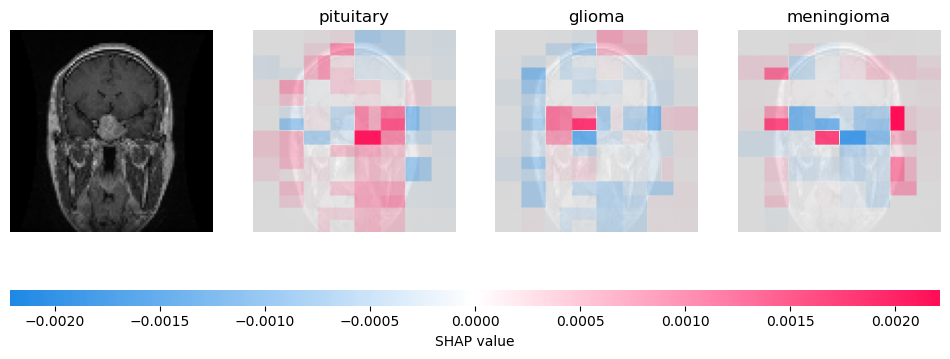

In [71]:
shap_values = explainer(
    x_data_tumor[288:289], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:3]
)
shap.image_plot(shap_values)

In [73]:
print(f"Correct Label: {y_data_tumor[281]}")

Correct Label: 2


There is no significant difference between the 4-class model (including "notumor") and the 3-class model (excluding "notumor") in terms of model performance and SHAP explanations.

## 3. Heart Disease

## 3.1 Background

According to the World Health Organization (WHO) Cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year. CVDs are a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions. More than four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidemia, or already established disease) need early detection and management, wherein a machine learning model can be of great help.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support


Importing the heart disease dataset:

In [ ]:
import pandas as pd

df = pd.read_csv("insert_your_path_and_file_name.csv")
print(df)
df.info()
df

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[918 rows x 12 columns]

Checking for duplicates:

In [ ]:
df.duplicated().sum()

0

Checking for missing values:

In [ ]:
nan_count = df.isna().sum()
print(nan_count)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Unique values:

In [ ]:
# show unique values
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

This gave us a first overview of the dataset and the data included. We saw that there are 12 attributes/features overall, including the target variable HeartDisease. Furthermore, there are no missing values or duplicates. We also got an overview of the datatypes of each attribute.

In [ ]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

## 3.2 Features:

Here we can see the different feautres/attributes according to which a heart disease is predicted. Each row is representing a different patient whereas each feature represents different health parameters for a given patient.

The different features are described as follows:


1.) Age: age of the patient in years. <br>
2.) Sex: sex of the patient (M for male and F for female) <br>
3.) ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic) <br>
4.) RestingBP: resting systolic blood pressure – the pressure when your heart pushes blood out around your body while resting (mm Hg) <br>
5.) Cholesterol: serum cholesterol (mm/dl) <br>
6.) FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise) <br>
7.) RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria) <br>
8.)MaxHR: maximum heart rate achieved (Numeric value between 60 and 202) <br>
9.) ExerciseAngina: exercise-induced angina (Y: Yes, N: No) <br>
10.) Oldpeak: oldpeak = ST Numeric value measured in depression (ST segment depression < than 0.5 mm is accepted in all leads; ST segment depression >= 0.5 mm is considered pathological) <br>
11.) ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping) <br>


Target attribute: HeartDisease: output class/ target values (1: heart disease, 0: Normal)


##  3.3 Exploratory Data Analysis

First, lets visualize all numerical and categorical features in the dataset regarding heart disease and normal resutls:

In [ ]:
Categorical = df.select_dtypes(include=['object'])
Numerical = df.select_dtypes(include=['int64', 'float64'])
print('Categorical features:\n', Categorical)
print('Numerical features:\n', Numerical)

Categorical features:
     Sex ChestPainType RestingECG ExerciseAngina ST_Slope
0     M           ATA     Normal              N       Up
1     F           NAP     Normal              N     Flat
2     M           ATA         ST              N       Up
3     F           ASY     Normal              Y     Flat
4     M           NAP     Normal              N       Up
..   ..           ...        ...            ...      ...
913   M            TA     Normal              N     Flat
914   M           ASY     Normal              N     Flat
915   M           ASY     Normal              Y     Flat
916   F           ATA        LVH              N     Flat
917   M           NAP     Normal              N       Up

[918 rows x 5 columns]
Numerical features:
      Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
0     40        140          289          0    172      0.0             0
1     49        160          180          0    156      1.0             1
2     37        130       

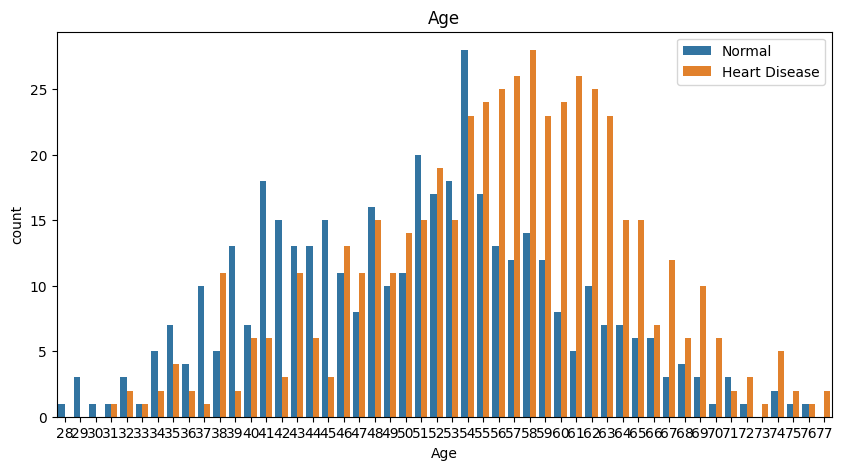

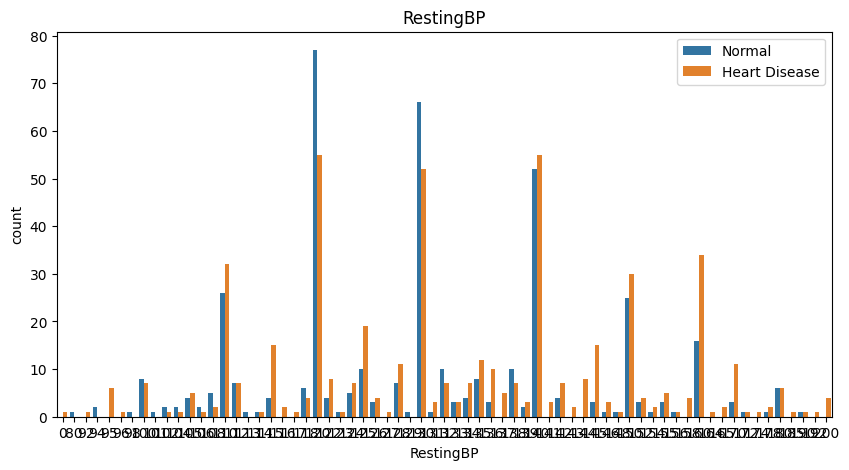

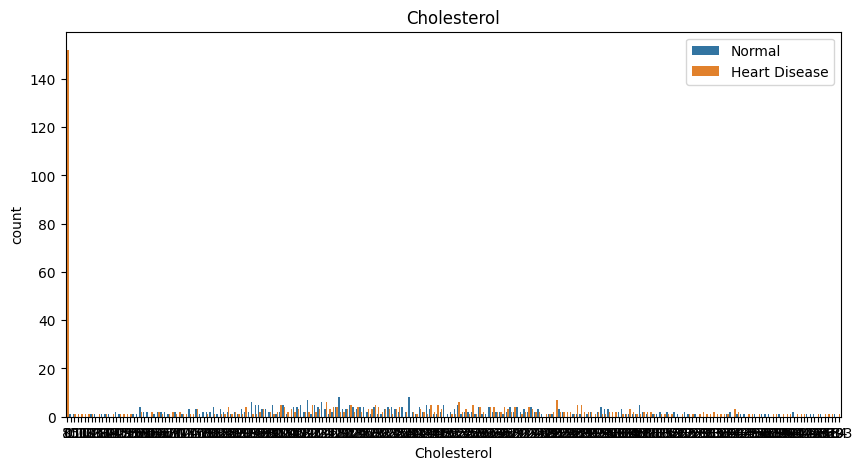

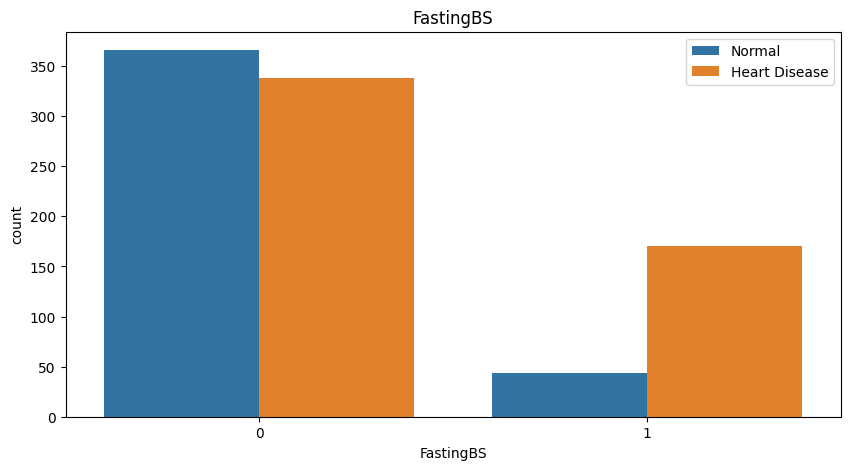

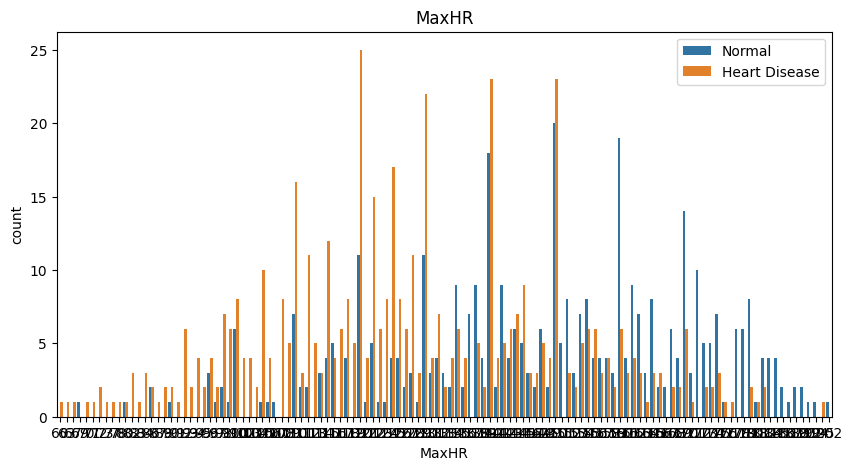

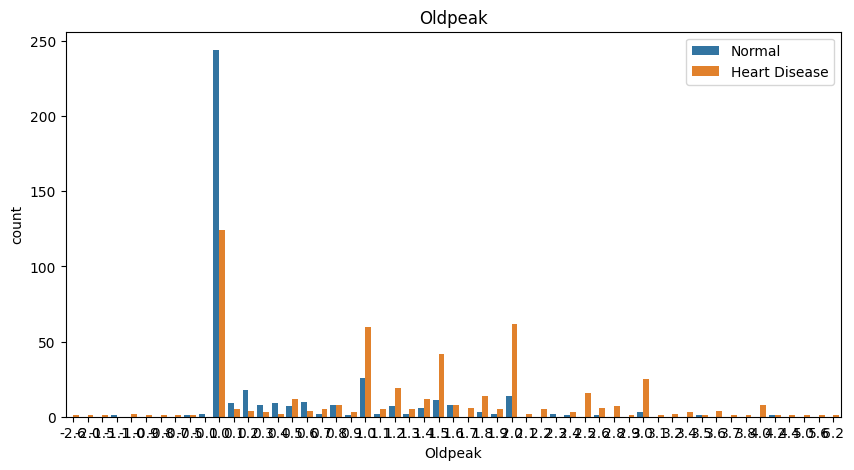

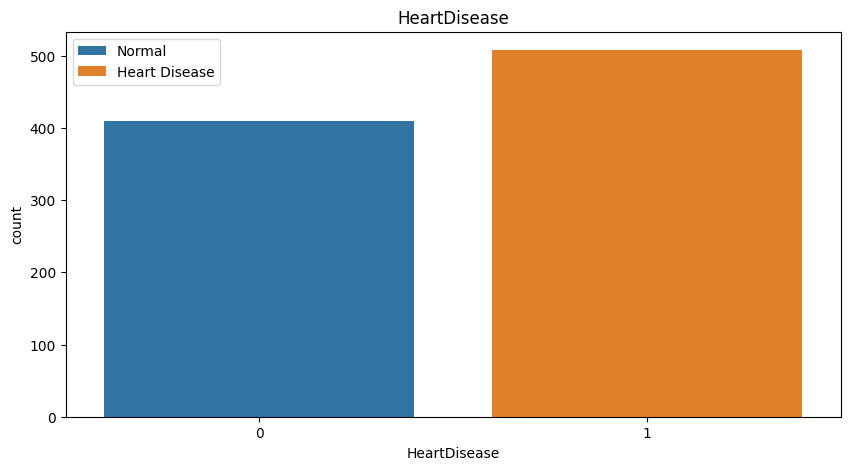

In [ ]:
# ploting numerical features with target
for i in Numerical:
    plt.figure(figsize=(10,5))
    sns.countplot(x=i, data=df, hue='HeartDisease')
    plt.legend(['Normal', 'Heart Disease'])
    plt.title(i)
    plt.show()

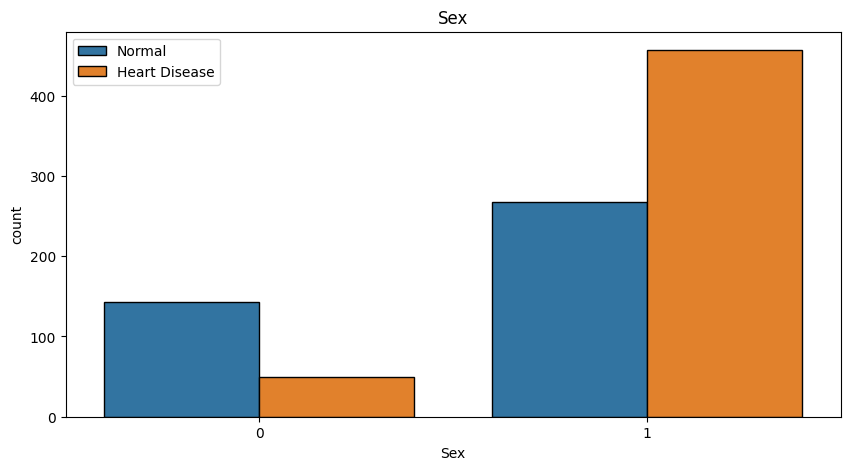

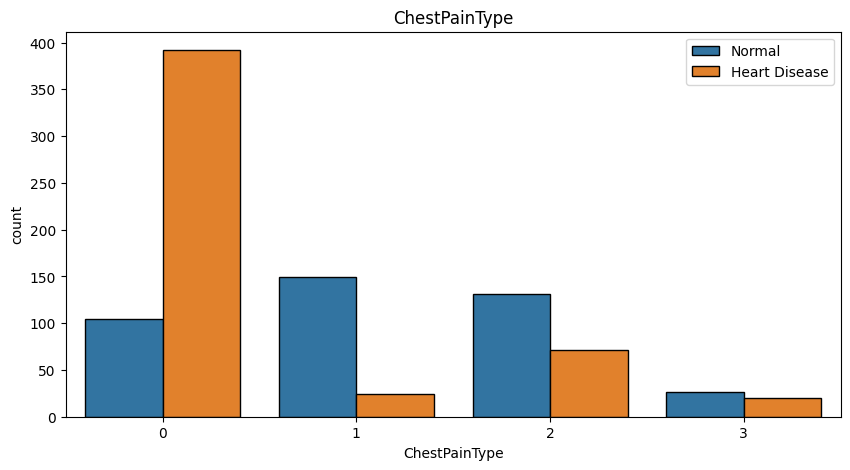

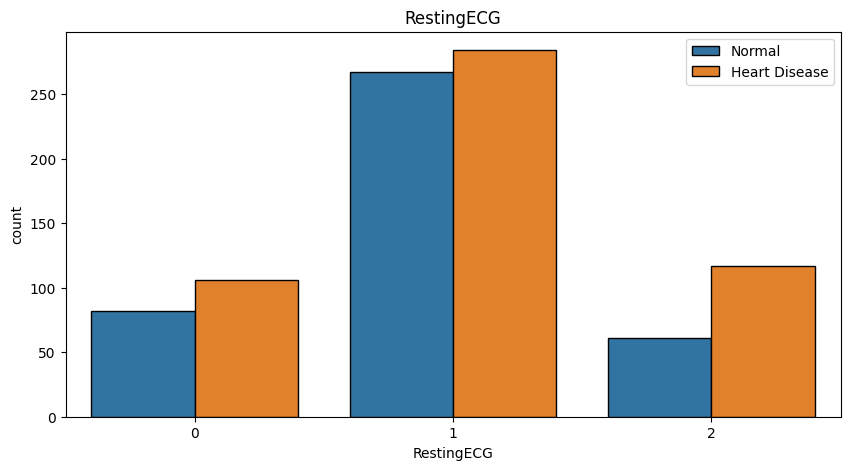

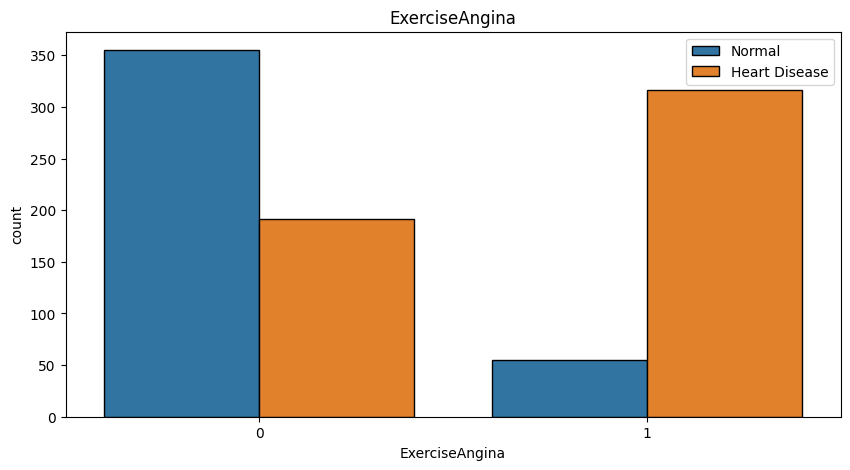

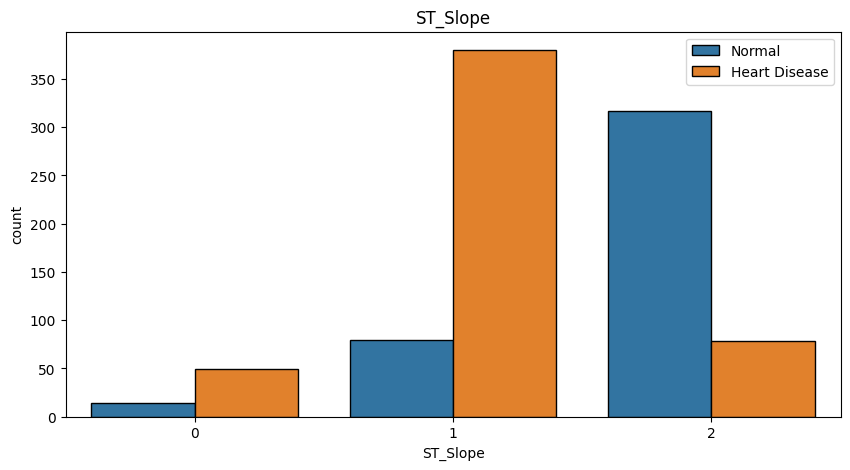

In [ ]:
#ploting categorical features with target
for i in Categorical:
    plt.figure(figsize=(10,5))
    sns.countplot(x=i, data=df, hue='HeartDisease', edgecolor='black')
    plt.legend(['Normal', 'Heart Disease'])
    plt.title(i)
    plt.show()

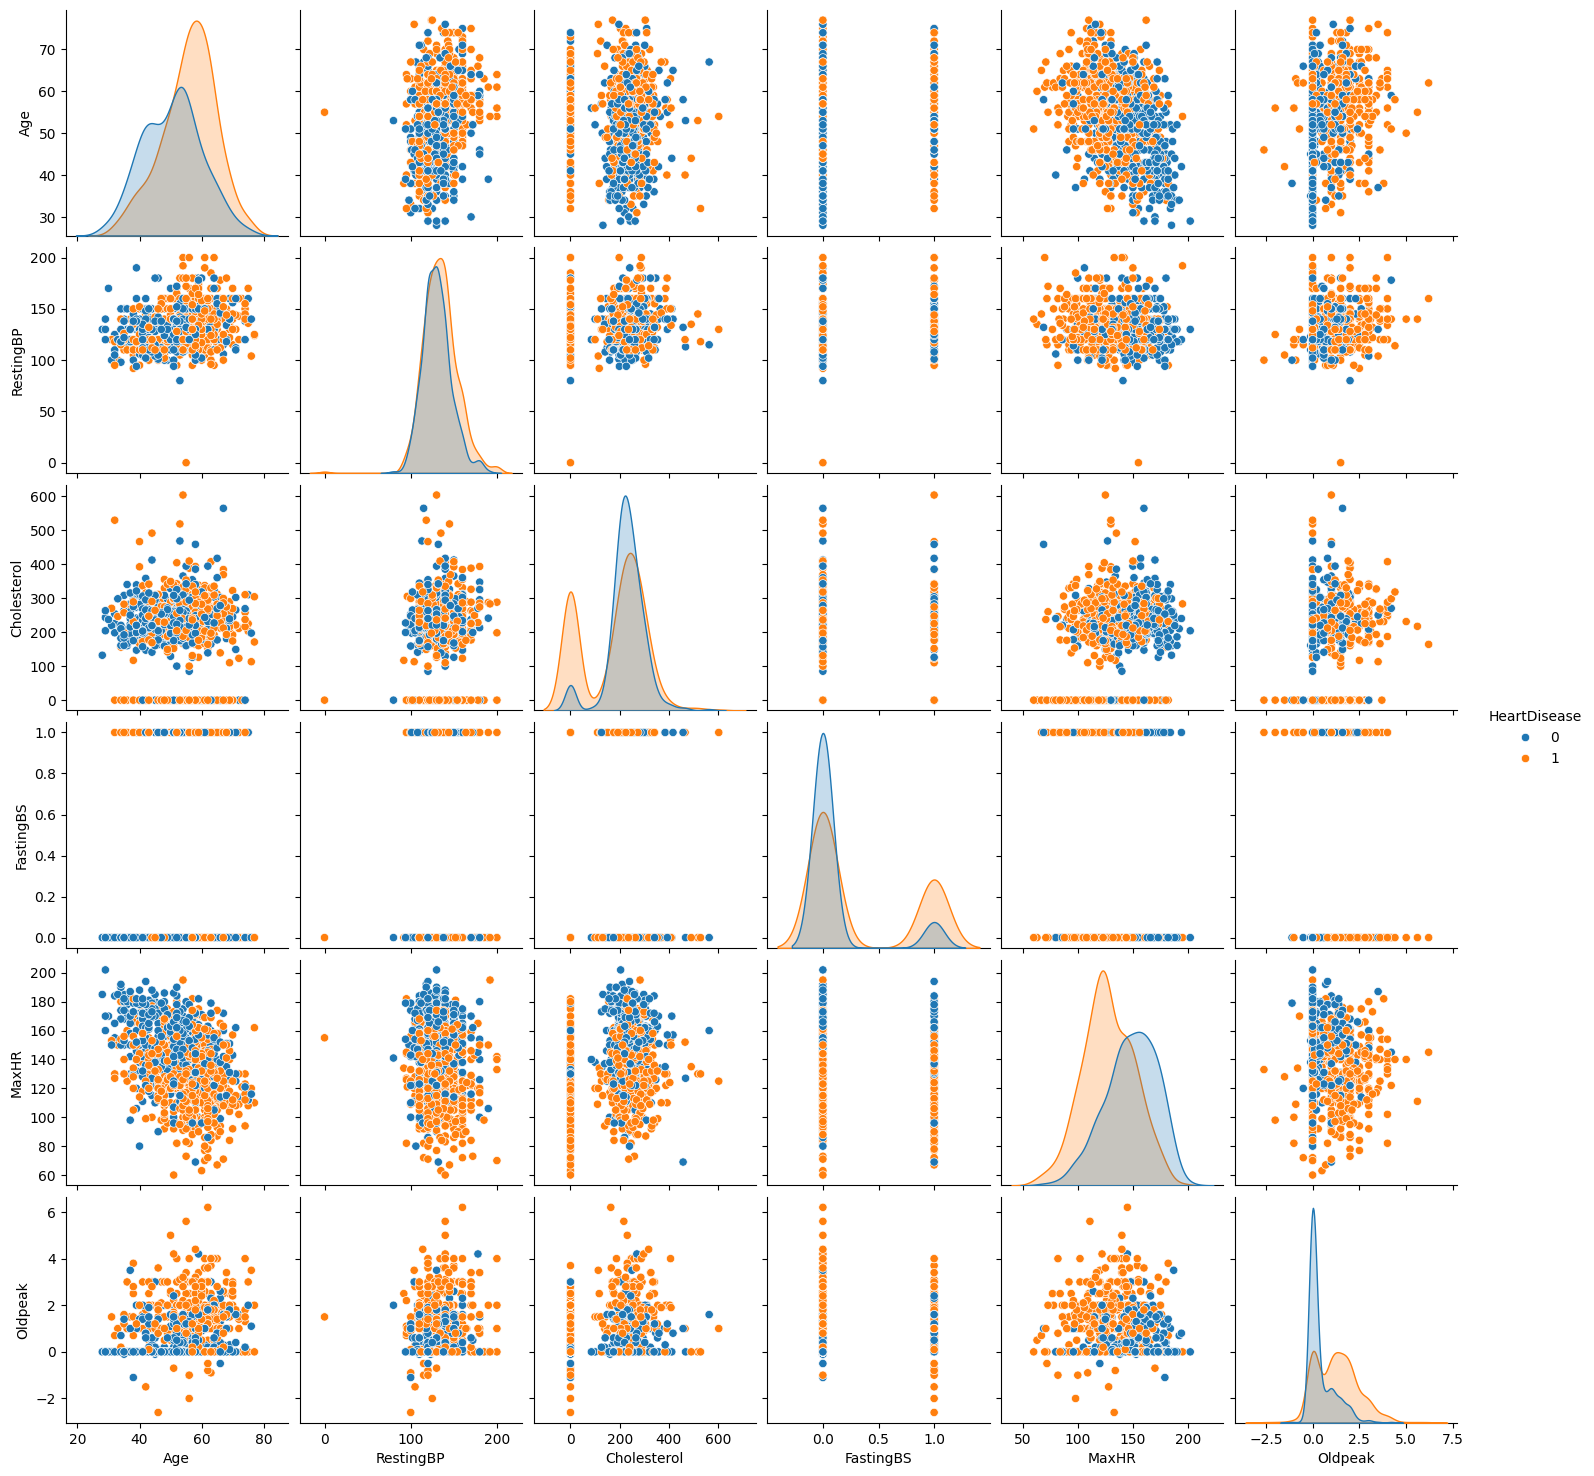

In [ ]:
#pairplot using target HeartDisease Column
sns.pairplot(df, hue='HeartDisease')
plt.show()

Taking a closer look at Age regarding Heart Disease and no Heart Disease:

<ipython-input-16-dd23024180f3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'][df['HeartDisease'] == 1], kde=True, color='red', label='Heart Disease')
<ipython-input-16-dd23024180f3>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'][df['HeartDisease'] == 0], kde=True, color=

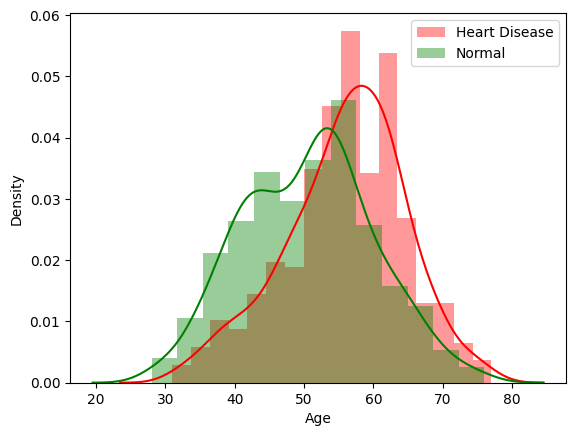

In [ ]:
sns.distplot(df['Age'][df['HeartDisease'] == 1], kde=True, color='red', label='Heart Disease')
sns.distplot(df['Age'][df['HeartDisease'] == 0], kde=True, color='green', label='Normal')
plt.legend()

In [ ]:
df.describe().round(1)

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
count  918.0      918.0        918.0      918.0  918.0    918.0         918.0
mean    53.5      132.4        198.8        0.2  136.8      0.9           0.6
std      9.4       18.5        109.4        0.4   25.5      1.1           0.5
min     28.0        0.0          0.0        0.0   60.0     -2.6           0.0
25%     47.0      120.0        173.2        0.0  120.0      0.0           0.0
50%     54.0      130.0        223.0        0.0  138.0      0.6           1.0
75%     60.0      140.0        267.0        0.0  156.0      1.5           1.0
max     77.0      200.0        603.0        1.0  202.0      6.2           1.0

Interestingly, we can see here that the minimum value for RestingBP (Resting Blood Preassure) and Cholesterol is 0, indicating that for some patients these values are 0 which is not possible.


In general, there 2 ways to deal with this issue.

- Impute with median or mean: This may be suitable if the number of 0 values is small.
- Remove the rows: If the number of rows with 0 values is very small, removing them might be reasonable.

First, check the numbe of rows where the ResingBP and/or the Cholesterol is 0.

In [ ]:
bp_zero_count = df[df['RestingBP'] == 0].shape[0]

print(f'Number of rows where RestingBP is 0: {bp_zero_count}')



cholesterol_zero_count = df[df['Cholesterol'] == 0].shape[0]

print(f'Number of rows where Cholesterol is 0: {cholesterol_zero_count}')

Number of rows where RestingBP is 0: 1
Number of rows where Cholesterol is 0: 172


In [ ]:
bp_zero_rows = df[df['RestingBP'] == 0]
print(bp_zero_rows)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1  


In [ ]:
# Remove rows where RestingBP is 0
df = df[df['RestingBP'] != 0]
# Verify removal
print(df.shape)  # Check the new number of rows and columns


(917, 12)


Replace the zero values with the mean of the non-zero values in the Cholesterol column.

In [ ]:
cholesterol_mean = df[df['Cholesterol'] != 0]['Cholesterol'].mean()

# Impute the zero values (using mean in this example)
df['Cholesterol'].replace(0, cholesterol_mean, inplace=True)

# Verify imputation and new feature
print(df[['Cholesterol']].describe())

print(df[['RestingBP']].describe())

       Cholesterol
count   917.000000
mean    244.635389
std      53.347125
min      85.000000
25%     214.000000
50%     244.635389
75%     267.000000
max     603.000000
        RestingBP
count  917.000000
mean   132.540894
std     17.999749
min     80.000000
25%    120.000000
50%    130.000000
75%    140.000000
max    200.000000


<ipython-input-21-b3232ed1e23d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cholesterol'].replace(0, cholesterol_mean, inplace=True)


In [ ]:
df.describe().round(1)

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
count  917.0      917.0        917.0      917.0  917.0    917.0         917.0
mean    53.5      132.5        244.6        0.2  136.8      0.9           0.6
std      9.4       18.0         53.3        0.4   25.5      1.1           0.5
min     28.0       80.0         85.0        0.0   60.0     -2.6           0.0
25%     47.0      120.0        214.0        0.0  120.0      0.0           0.0
50%     54.0      130.0        244.6        0.0  138.0      0.6           1.0
75%     60.0      140.0        267.0        0.0  156.0      1.5           1.0
max     77.0      200.0        603.0        1.0  202.0      6.2           1.0

Next, the categorial variables are encoded with integer/label encoding:

These variables are:

Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope

In [ ]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

<ipython-input-23-fb355eb84eb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])
<ipython-input-23-fb355eb84eb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])
<ipython-input-23-fb355eb84eb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
df.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140        289.0          0           1   
1   49    0              2        160        180.0          0           1   
2   37    1              1        130        283.0          0           2   
3   48    0              0        138        214.0          0           1   
4   54    1              2        150        195.0          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122               0      0.0         2             0

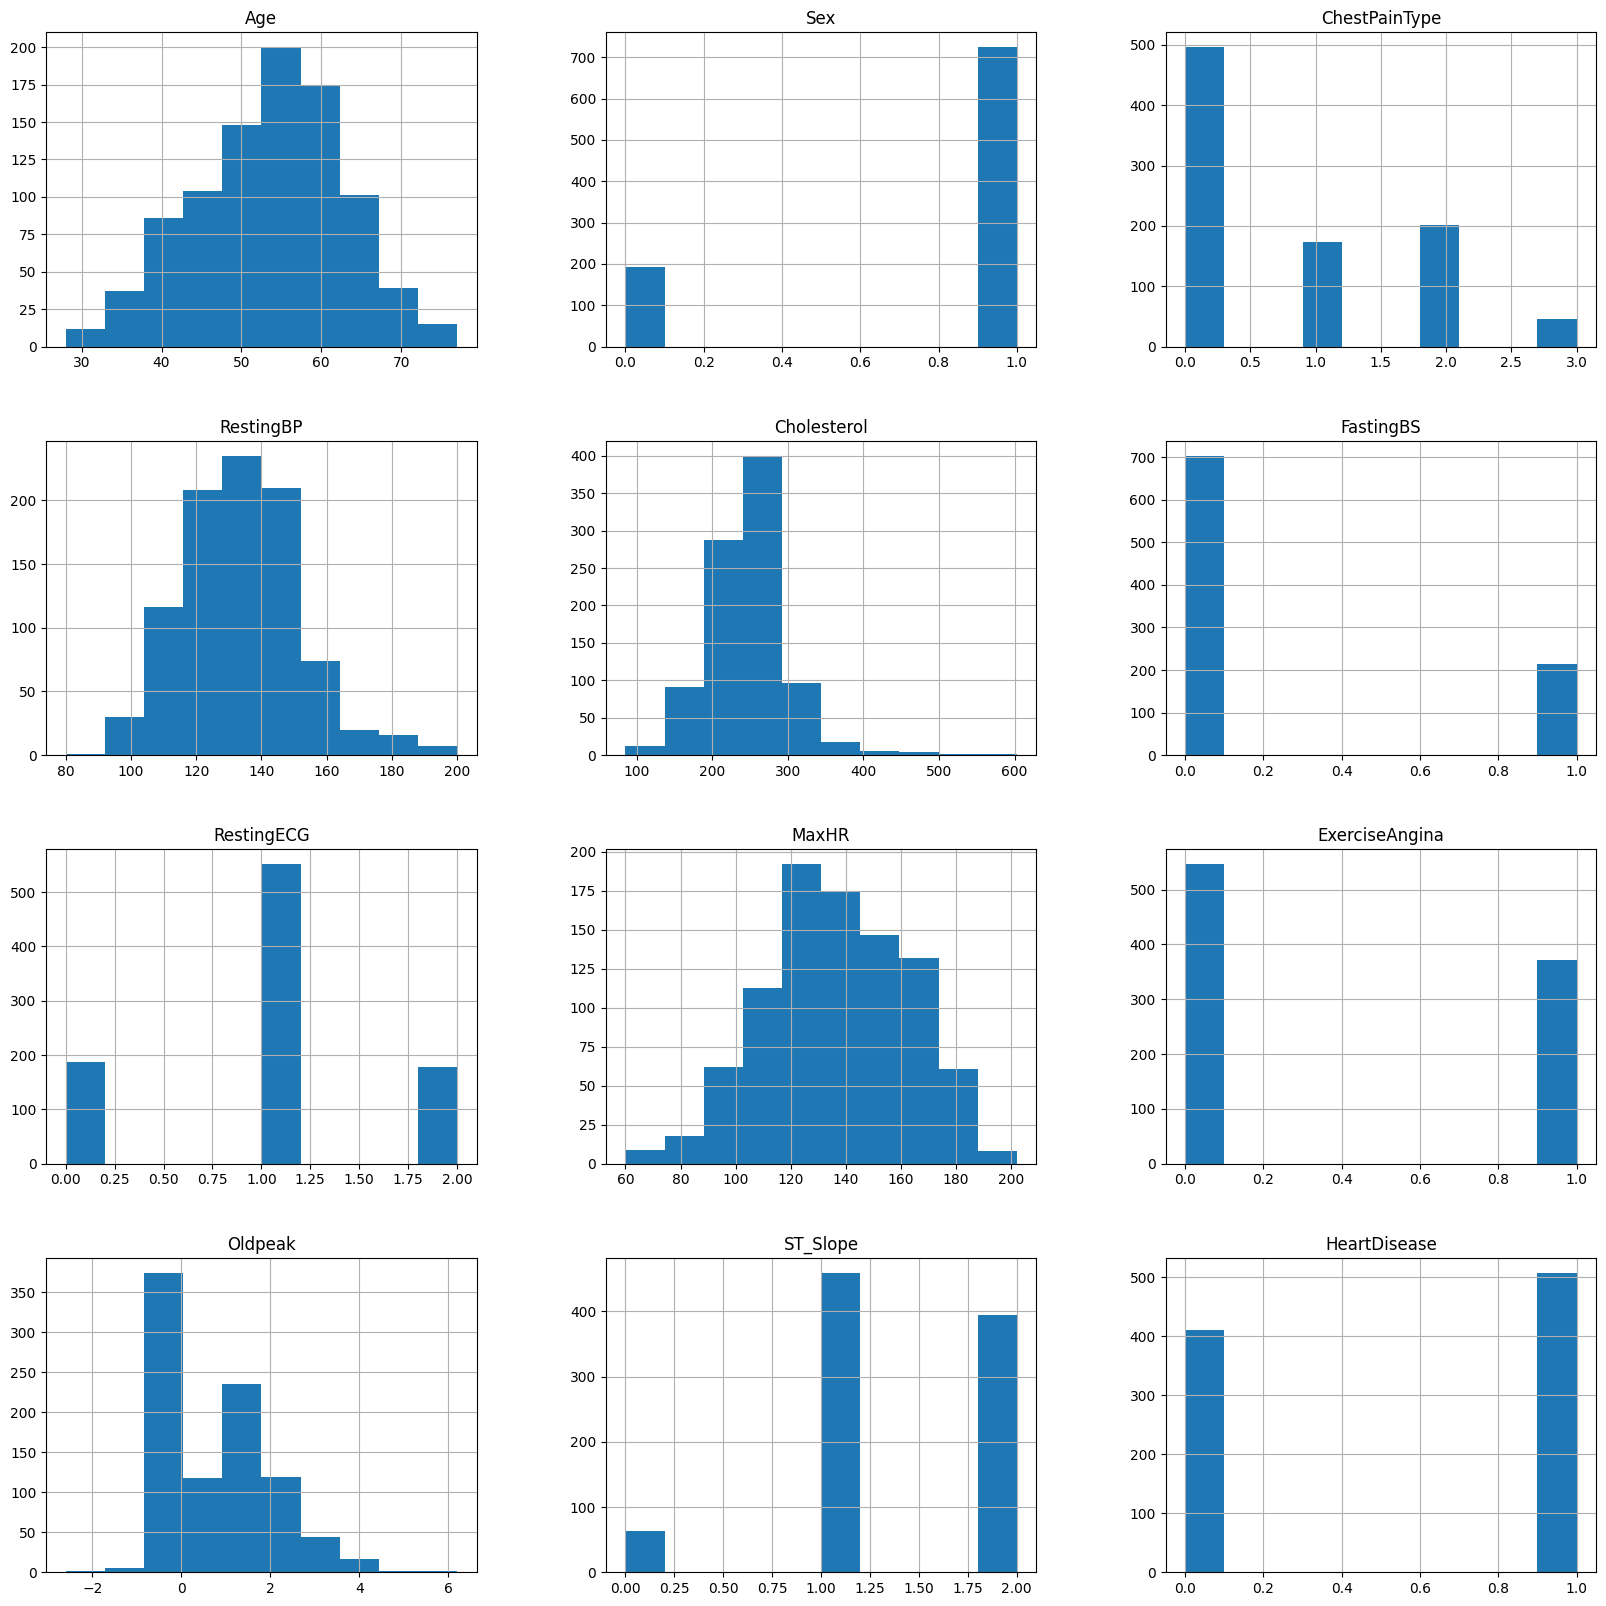

In [ ]:
df.hist(figsize=(20,20));

Next we visualize the correlation matrix in order to gain a deeper insight into the dataset. After analysis, we find no significant correlations among input features (indicating no multicollinearity). Consequently, we decide to incorporate all of the features into our model.

In [ ]:
df.corr()

Age       Sex  ChestPainType  RestingBP  Cholesterol  \
Age             1.000000  0.055670      -0.077439   0.263084     0.053374   
Sex             0.055670  1.000000      -0.127408   0.009427    -0.101721   
ChestPainType  -0.077439 -0.127408       1.000000  -0.011020    -0.092763   
RestingBP       0.263084  0.009427      -0.011020   1.000000     0.083076   
Cholesterol     0.053374 -0.101721      -0.092763   0.083076     1.000000   
FastingBS       0.198170  0.120424      -0.072461   0.067823     0.043015   
RestingECG     -0.007487  0.071553      -0.072625   0.023455    -0.063612   
MaxHR          -0.382280 -0.189668       0.288465  -0.109693    -0.017244   
ExerciseAngina  0.216017  0.191226      -0.354027   0.153064     0.077578   
Oldpeak         0.258563  0.105444      -0.178367   0.174252     0.053039   
ST_Slope       -0.268217 -0.150408       0.214582  -0.082155    -0.069737   
HeartDisease    0.282012  0.305118      -0.388592   0.117990     0.094113   

                FastingBS  RestingECG     MaxHR  ExerciseAngina   Oldpeak  \
Age              0.198170   -0.007487 -0.382280        0.216017  0.258563   
Sex              0.120424    0.071553 -0.189668        0.191226  0.105444   
ChestPainType   -0.072461   -0.072625  0.288465       -0.354027 -0.178367   
RestingBP        0.067823    0.023455 -0.109693        0.153064  0.174252   
Cholesterol      0.043015   -0.063612 -0.017244        0.077578  0.053039   
FastingBS        1.000000    0.087074 -0.131067        0.059988  0.053062   
RestingECG       0.087074    1.000000 -0.179339        0.077545 -0.020452   
MaxHR           -0.131067   -0.179339  1.000000       -0.370023 -0.161213   
ExerciseAngina   0.059988    0.077545 -0.370023        1.000000  0.409494   
Oldpeak          0.053062   -0.020452 -0.161213        0.409494  1.000000   
ST_Slope        -0.176196   -0.006768  0.344047       -0.429483 -0.501735   
HeartDisease     0.267994    0.057393 -0.401410        0.495490  0.403638   

                ST_Slope  HeartDisease  
Age            -0.268217      0.282012  
Sex            -0.150408      0.305118  
ChestPainType   0.214582     -0.388592  
RestingBP      -0.082155      0.117990  
Cholesterol    -0.069737      0.094113  
FastingBS      -0.176196      0.267994  
RestingECG     -0.006768      0.057393  
MaxHR           0.344047     -0.401410  
ExerciseAngina -0.429483      0.495490  
Oldpeak        -0.501735      0.403638  
ST_Slope        1.000000     -0.558541  
HeartDisease   -0.558541      1.000000

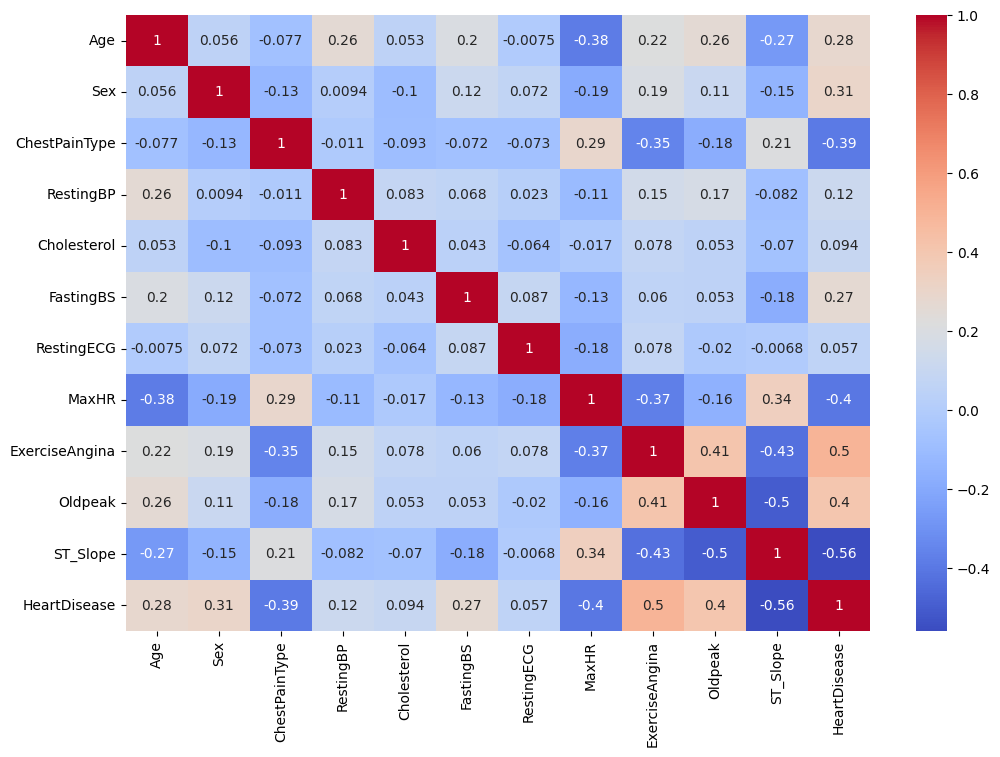

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

Plotting the number of observations for each target value we can see that there is an uneven distribtuion. This class imbalance can introduce bias in favor of the majority class (heart disease) and might influence the performance of machine learning models. This issue will be tackled in the next step, the data preprocessing.

<ipython-input-28-b735cce510da>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df.HeartDisease.value_counts().index, y=df.HeartDisease.value_counts(), palette="Set2")


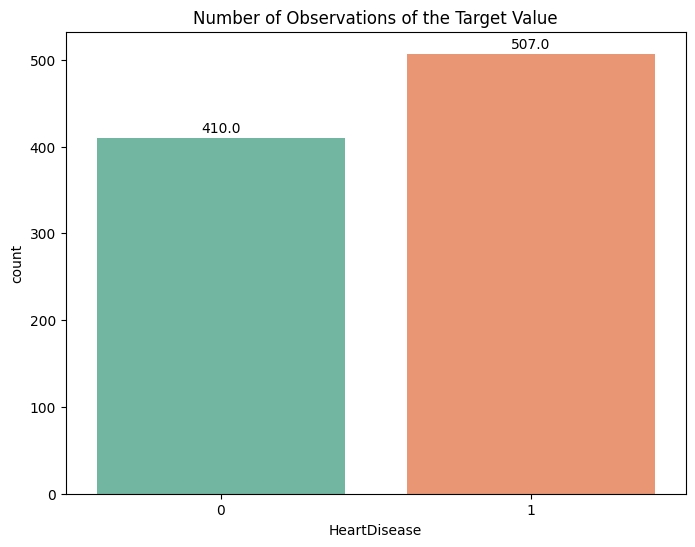

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=df.HeartDisease.value_counts().index, y=df.HeartDisease.value_counts(), palette="Set2")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="center",
        xytext=(0, 7),
        textcoords="offset points",
    )
plt.title("Number of Observations of the Target Value")
plt.show()

## 3.4 Data Preprocessing

1. Split the dataset in X (input data) and Y (target data)
2. Split the data in training and test data
3. Create balanced classes for training (SMOTE)
4. Standardize the features

1. Split the dataset in X (input data) and Y (target data)

In [ ]:
X = df.iloc[:,:-1]
Y = pd.get_dummies(df.iloc[:,-1])


In [ ]:
X.shape

(917, 11)

In [ ]:
Y.shape

(917, 2)

2. Split the data in training and test data

In [ ]:
X_tr, X_te, ytr, yte = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

3. Create balanced classes for training (SMOTE)

In [ ]:
X_tr.value_counts()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  MaxHR  ExerciseAngina  Oldpeak  ST_Slope
28   1    1              130        132.0        0          0           185    0               0.0      2           1
58   1    0              128        259.0        0          0           130    1               3.0      1           1
                         130        263.0        0          1           140    1               2.0      1           1
                         132        458.0        1          1           69     0               1.0      0           1
                         135        222.0        0          1           100    0               0.0      2           1
                                                                                                                   ..
50   1    0              145        264.0        0          1           150    0               0.0      1           1
          2              129        196.0        0          1

In [ ]:
ytr.value_counts()

0      1    
False  True     407
True   False    326
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

# Convert ytr back to single column of class labels
ytr_single_column = ytr.idxmax(axis=1)

# Apply SMOTE
smote = SMOTE(random_state=1)
X_tr, ytr_resampled_single_column = smote.fit_resample(X_tr, ytr_single_column)

# Convert ytr_resampled back to one-hot encoding
ytr= pd.get_dummies(ytr_resampled_single_column)

print(ytr.value_counts())

0      1    
False  True     407
True   False    407
Name: count, dtype: int64


4. Standardize the features

Standardization ensures that all features contribute equally to the model training by bringing them to a similar scale. This prevents features with larger ranges from dominating the learning process. It also improves the model performance as many machine learning algorithms perform better or converge faster when features are on a similar scale and centered around zero.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform both training and testing data
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

In [ ]:
print("Scaled Training Data:")
print(X_tr[:5].round(2))


Scaled Training Data:
[[ 0.84  0.57 -0.84  0.44 -0.66 -0.52 -1.54  0.01  1.32  1.    1.04]
 [-0.14 -1.77  1.28 -0.42  0.5  -0.52  0.05  0.05 -0.76 -0.8   1.04]
 [ 1.27 -1.77 -0.84  1.02 -0.34 -0.52 -1.54 -0.96 -0.76  0.15 -0.61]
 [-0.36  0.57 -0.84  0.44 -2.06 -0.52  0.05 -0.11 -0.76 -0.8   1.04]
 [-0.91  0.57 -0.84 -0.13 -0.45 -0.52  1.64 -0.32  1.32  0.15 -0.61]]


## 3.5 Model Training:  ANN with one output

towards 0 = no heart disease; and towards 1 = heart disease with a threshold of 0.5


In [ ]:
tf.random.set_seed(16)
np.random.seed(16)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(X_tr.shape[1],), activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



# Early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model

history = model.fit(X_tr, ytr, epochs=500,
                    batch_size=32,
                    validation_data=(X_te, yte),
                    callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_te, yte)
print(f"Final Test Accuracy: {test_accuracy:.2%}")

# Predictions
y_pred_prob = model.predict(X_te)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded yte back to class labels
y_true = np.argmax(yte, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on test set: {accuracy:.2%}")

Epoch 1/500
26/26 [==============================] - 1s 13ms/step - loss: 0.5818 - accuracy: 0.7064 - val_loss: 0.4464 - val_accuracy: 0.8098
Epoch 2/500
26/26 [==============================] - 0s 4ms/step - loss: 0.4418 - accuracy: 0.8108 - val_loss: 0.3657 - val_accuracy: 0.8478
Epoch 3/500
26/26 [==============================] - 0s 4ms/step - loss: 0.3906 - accuracy: 0.8366 - val_loss: 0.3369 - val_accuracy: 0.8641
Epoch 4/500
26/26 [==============================] - 0s 5ms/step - loss: 0.3632 - accuracy: 0.8440 - val_loss: 0.3303 - val_accuracy: 0.8913
Epoch 5/500
26/26 [==============================] - 0s 6ms/step - loss: 0.3486 - accuracy: 0.8538 - val_loss: 0.3262 - val_accuracy: 0.8913
Epoch 6/500
26/26 [==============================] - 0s 6ms/step - loss: 0.3363 - accuracy: 0.8636 - val_loss: 0.3255 - val_accuracy: 0.8913
Epoch 7/500
26/26 [==============================] - 0s 5ms/step - loss: 0.3276 - accuracy: 0.8661 - val_loss: 0.3247 - val_accuracy: 0.8913
Epoch 8/500


In [30]:
# saving the trained model into a keras file
#model.save('heart_disease_model_1_output.keras')

Loading the saved and trained model with 89.13% test accuracy in again:


In [10]:
#model = tf.keras.models.load_model('heart_disease_model_1_output.keras')

In [ ]:
X_te.shape


(184, 11)

In [ ]:
ytr = np.argmax(ytr, axis=1)
yte = np.argmax(yte, axis=1)

Confusion matrix:

6/6 [==============================] - 0s 4ms/step


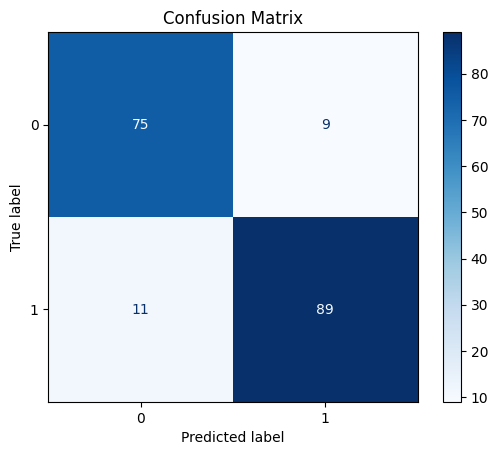

accuracy =  0.8913043478260869
precision =  0.9081632653061225
recall =  0.89
f1 score =  0.8989898989898989


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred_prob = model.predict(X_te)
y_pred = (y_pred_prob > 0.5).astype(int)


# Convert one-hot encoded yte back to class labels




cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print('accuracy = ', accuracy_score(y_true, y_pred))
print('precision = ', precision_score(y_true, y_pred))
print('recall = ', recall_score(y_true, y_pred))
print('f1 score = ', f1_score(y_true, y_pred))

Accuracy (0.8913): This indicates that the model correctly classified approximately 89.13% of the instances. Accuracy is the ratio of correctly predicted instances to the total instances. However, it can be misleading if the dataset is imbalanced.

Precision (0.9082): This shows that when the model predicts the positive class, it is correct approximately 90.82% of the time. Precision is the ratio of true positive predictions to the sum of true positive and false positive predictions. It is a good metric when the cost of false positives is high.

Recall (0.89): This indicates that the model correctly identifies 89% of the actual positive instances. Recall is the ratio of true positive predictions to the sum of true positive and false negative predictions. It is crucial when the cost of false negatives is high.

F1 Score (0.8990): This is the harmonic mean of precision and recall, providing a balance between the two. An F1 score of 0.8990 suggests the model maintains a good balance between precision and recall.

## 3.6 SHAP Globally

In [ ]:
shap.initjs()

In [ ]:
X_tr_onehot = shap.kmeans(X_tr, 10)

Computing the shap values for the test set:

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_tr_onehot)
shap_values = explainer.shap_values(X_te)

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/184 [00:00<?, ?it/s]

640/640 [==============================] - 1s 1ms/step


In [ ]:
shap_values.shape

(184, 11, 1)

The shape of the shap_values is (184, 11, 1).

184: corresponds to the number of samples or instances in the dataset. Specifically, it corresponds to *X_tr_onehot = shap.kmeans(X_tr, 10)*, where only a part of the samples are taken for the shap values calculation.

11: represents the number of features.

1: This dimension is 1 since it is a binary classification problem (heart disease or no heart disease)For each feature in each sample, 1 SHAP value is calculated. Hence, for each feature, there is only one SHAP value because of the single output value of the model (towards 0 = no heart disease; towards 1 = heart disease).



**Shape Interpretation**: The shape (184, 11, 1) indicates that for each of the 184 samples, for each of the 11 features, 1 SHAP value has been computed (output towards 0 = no heart disease and output towards 1 = heart disease (threshold = 0.5)).

In [ ]:
features = X.columns.tolist()

In [ ]:
X_te_df = pd.DataFrame(X_te)

### 3.6.1 Beeswarm plot

The Beeswarm plot shows us all shap values. A shap value is computed for each feature, for each observation.



 **Label encoded features in detail:**

1. **ST-Slope:** <br>

Your heart beats because of electrical signals telling it when to contract (squeeze) and relax. This process repeats in a regular cycle, keeping blood pumping through your body. An ECG records these electrical signals and shows them as a series of waves. <br>

The ST-Segment is a short but important part of this ECG wave that can give important clues about the heart's health, especially about the oxygen supply to the heart muscle. <br>



It always depends on the context, but in general: <br>

**2  --> up sloping = usually healthy** <br>
**1** --> flat = **normal but can be concerning if significantly depressed or elevated. <br>
0** --> downsloping =  **usually concerning** <br>
<br>

2. **Excercise Angina:**

Exercise Angina is **pain in the chest that comes with exercise, stress**, or other things that make the heart work harder. It is an extremely common symptom of coronary artery disease, which is caused by cholesterol-clogged coronary arteries.
<br>
3. **Fasting blood sugar**:

Fasting blood sugar is a common blood test to diagnose diabetes and prediabetes, which is a common risk factor for heart disease. In this case, if the FastingBS > 120 mg/dl = 1, otherwise = 0. (Label encoding)

<br>

4. **Oldpeak:**

The Oldpeak is a value in a cardiac context representing the depression observed between the first and second parts of the ST segment in an ECG.

 value **< than 0.5 mm is accepted** in all leads; **ST segment depression >= 0.5 mm is considered pathological**

<br>

5. **Chest Pain Type:**

asy = 0 asymptomatic <br>
ata = 1 atypical angina <br>
nap = 2 non-anginal pain <br>
ta =  3 typical anginal <br>

<br>
<br>
All ohter features should be clear given the feature descriptions for the dataset in the beginning.other features should be clear,





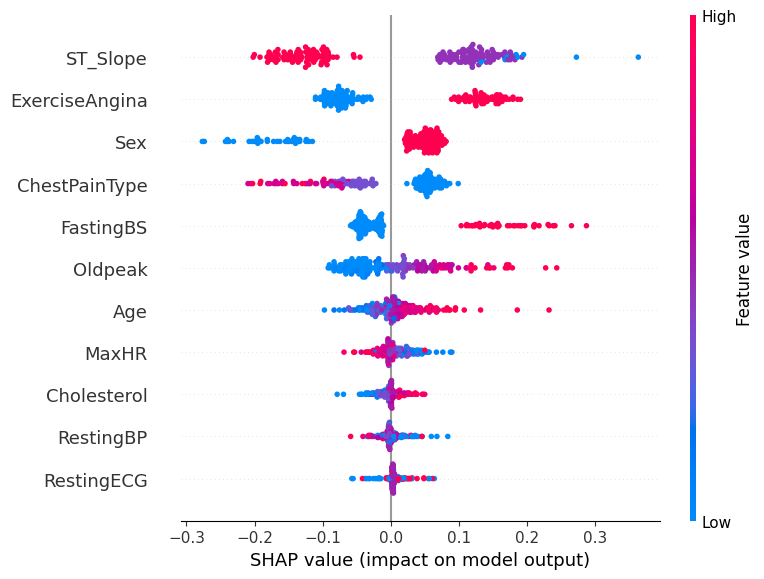

In [ ]:
tshap.summary_plot(shap_values[:,:,0], X_te, feature_names= features)

The beeswarm plot provides a detailed overview of how each feature influences the model's output across the entire dataset. The beeswarm plot shows each feature's overall or generalized impact on all the model's predictions across all observations. Each dot in the plot represents a shap value for the respective feature of a single observation in the dataset.

The x-axis of the plot represents the SHAP values. A positive SHAP value pushes the model's prediction towards 1 (heart disease), while a negative SHAP value pushes the prediction towards 0 (no heart disease).

The more widespread the shap values (dots) for each feature are, the higher the general influence of the feature on the model prediction in general (over the entire dataset). The narrower the shap values (dots) are distributed for each feature and center around a shap value of 0, the less impact these features have on the model prediction in general over the entire dataset.

We can see that an upsloping ST-segment (dots colored in red and with a feature value of 2 because of label encoding) are pushing the model towards a prediction for no heart disease (negative shap values). This makes sense since an upsloaping ST-segment is generally considered healthy. On the other hand, flat or downsloping ST-segments have positive shap values, contributing and pushing the model towards a prediction of a heart disease. We see that the dots (Shap values) are the most widespread for this feature, indicating that the ST-Slope feature has the greatest influence on the prediction of the model in general.

We also see that having exercise angina or not has a significant general impact on the model's prediction. Having exercise angina (red dotted positive shap values) generally pushes the model's prediction towards heart disease. Not having exercise angina (blue dotted negative shap values) pushes the model towards no heart disease prediction.


We can also see that being male pushes the model to predict a heart disease for this dataset. Since the dataset has more males with heart disease, the model might learn to associate the male gender with a higher likelihood of heart disease. The fewer observations for females and their lower incidence of heart disease means the model has less information to learn about females, potentially leading to a stronger bias towards associating males with heart disease. The model might be biased due to the imbalance in the dataset. If males are overrepresented and have a higher rate of heart disease, the model might be more sensitive to this feature and thus give it more weight in the prediction.


We can also see that the Type of Chestpain, fasting blood sugar as well as oldpeak (related to the ST-Slope) have a moderate general impact on the prediction of the model, as well as the age of the patient.

Again, the narrower the dots (shap values) for each feature, the less general impact the feature has on the model prediction.


Also, cholesterol probably does not have such a high impact in this case because, for 172 observations in the original dataset, the cholesterol levels were 0 and thus have been imputed with the mean value of all available cholesterol levels in the dataset.

Next lets have a look at the mean-shap plot. For each feature, this plot gives the absolute mean shap value across all instances (patients) in our dataset. Features that tend to make significant contributions to predictions of the model will have high mean shap values. This plot tells us which features are most important in general:

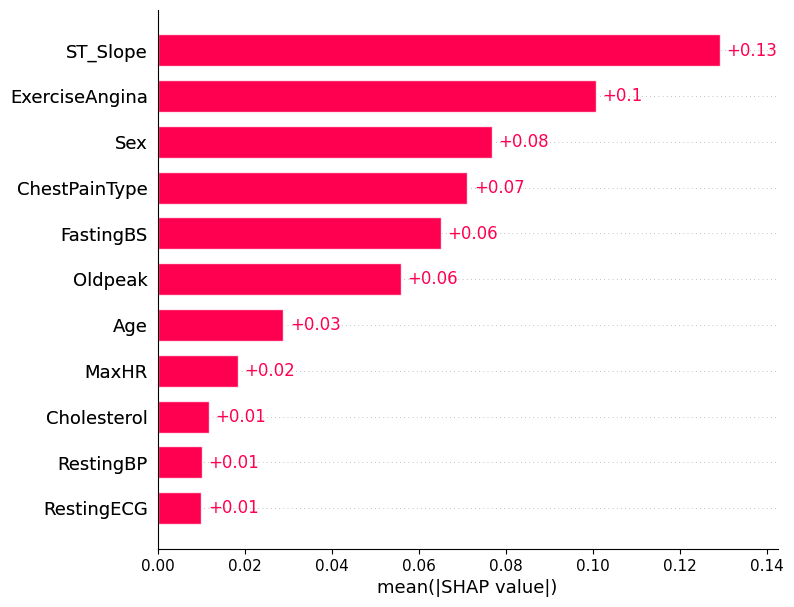

In [ ]:
shap_values_explanation = shap.Explanation(shap_values[:,:,0],
                                           feature_names=features,
                                           data=X_te_df.values)

shap.plots.bar(shap_values_explanation, max_display=11)

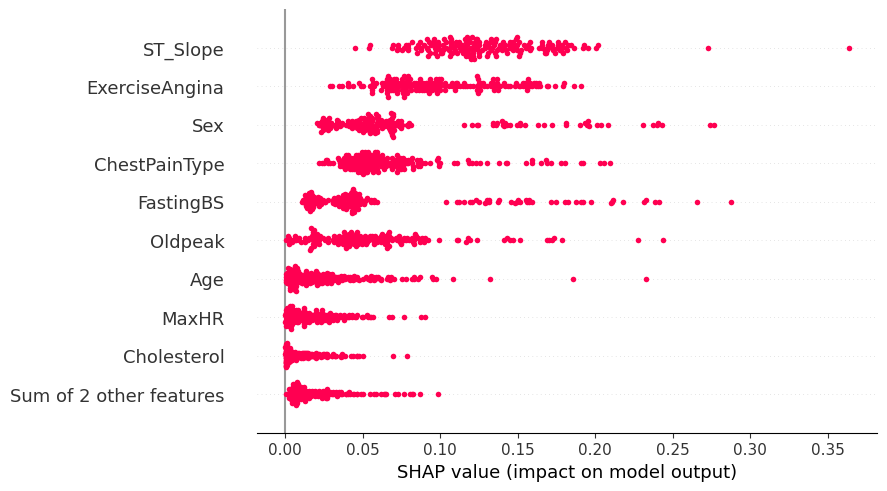

In [ ]:
shap.plots.beeswarm(shap_values_explanation.abs, color="shap_red")

**Dependence scatter plot shows the higher the age, the higher the chance for the model to predict a heart disease:**

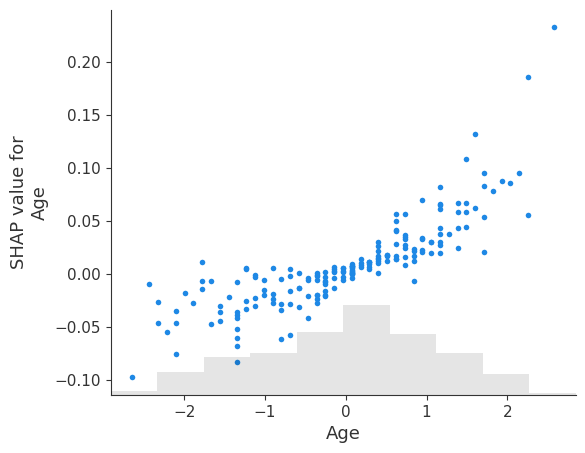

In [ ]:
shap.plots.scatter(shap_values_explanation[:,0])

Also, the higher the cholesterol, the higher the chance for the model to predict heart disease:

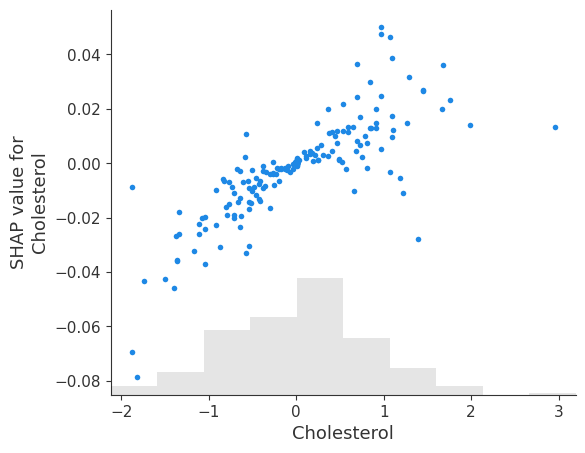

In [ ]:
shap.plots.scatter(shap_values_explanation[:,4])

Also, the higher the oldpeak (measured in milimeters), the higher the chance for the model to predict heart disease:

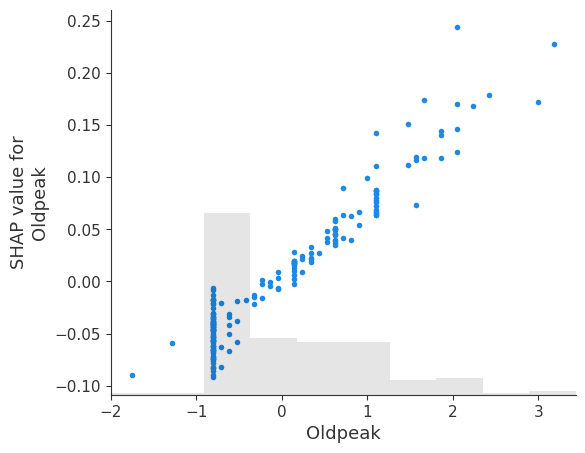

In [ ]:
shap.plots.scatter(shap_values_explanation[:,9])

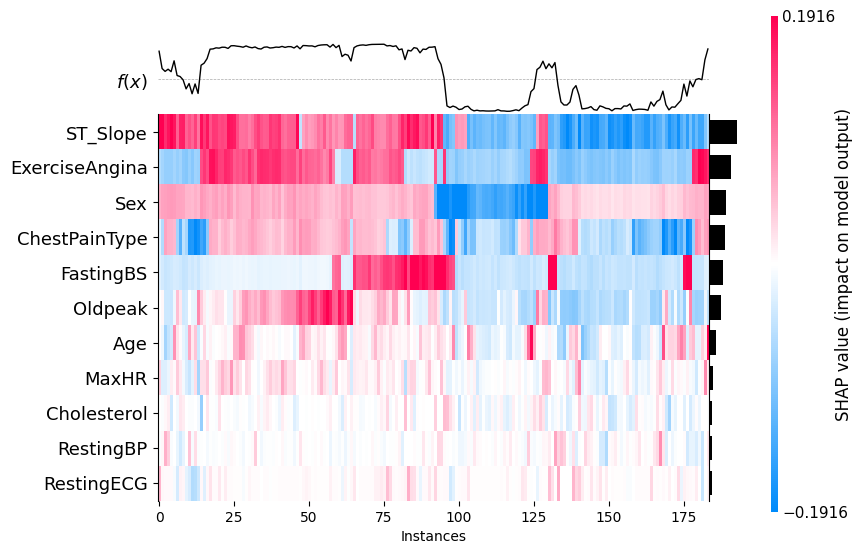

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values_explanation, max_display = 11)

## 3.7 Shap Locally

In [ ]:
X_te.shape

(184, 11)

In [ ]:
# Create a KernelExplainer
explainer = shap.KernelExplainer(model.predict, X_tr_onehot)

1/1 [==============================] - 0s 33ms/step


Computing shap values for the first observation (first row) or first patient to be exact from the X_te test dataset. It computes SHAP values specifically for that single observation.

In [ ]:
shap_values_1 = explainer.shap_values(X_te[1,:])

640/640 [==============================] - 1s 1ms/step


Now that we have only computed the shape value for the first row (patient) in our X_te test set, we can see that the shap values for this observation have a shape of (11, 2), meaning that a shap value has been computed for each feature for this single observation.

In [ ]:
shap_values_1.shape

(11, 1)

Lets see what the model predicts:

In [ ]:
model.predict(X_te)[1,:]

6/6 [==============================] - 0s 2ms/step


array([0.9332918], dtype=float32)

We can see that the model predicted that this patient has a heart disease with a probability of around 93.3%. We can check if the model is correct by viewing the target variable for this observation/patient:

In [ ]:
yte[1]

1

We can see that the target value (true value) for this patient is 1, indicating that this patient has indeed a heart disease. Lets have a look at the health data for this patient by converting back the standard-scaled feature to its original values:

In [ ]:
#converting back the standard-scaled feature back to its original values
standard_scaled_values = X_te[1, :]

# Get the mean and standard deviation used during the fit
mean = scaler.mean_
scale = scaler.scale_

# Reverse the standard scaling
original_values = standard_scaled_values * scale + mean

print(original_values)

[ 50.    1.    0.  133.  218.    0.    1.  128.    1.    1.1   1. ]


**Observation:**

We can see that this patient is 50 years, male chestpain type asymptomatic chestpain type. The patient has a flat ST_Slope (1) and has exercise angina, meaning that he has pain in the chest that comes with exercise, stress, or other things that make the heart work harder and is an extremely common symptom of coronary artery disease, which is caused by cholesterol-clogged coronary arteries.

The patient also has a concerning oldpeak.



In [ ]:
X.iloc[529,:]

Age                50.0
Sex                 1.0
ChestPainType       0.0
RestingBP         133.0
Cholesterol       218.0
FastingBS           0.0
RestingECG          1.0
MaxHR             128.0
ExerciseAngina      1.0
Oldpeak             1.1
ST_Slope            1.0
Name: 530, dtype: float64

The following can be interpreted: the model's prediction is a heart disease with a 93.3% chance. We can also clearly see which variables push up the result or influence the decision of the model to predict a heart disease with a probability of 93.3%.

This is because we are looking from the perspective of heart disease, where a prediction towards 1 indicates heart disease and a prediction towards 0 indicates no heart disease.

We can see here that Exercise Angina has the biggest impact for this prediction followed by the ST-Slope and the fact that the patient is male. Also Chestpain type, the Oldpeak as well as the maximum heartrate of the patient contribute to this decision. However, we can also see that some features are "pushing" the model against the prediction for a 100% heart disease. The highest impact against a prediction of a 100% heart disease being the fasting blood sugar of this patient, as it is below the threshold for a concerning level.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_1[:, 0], X_te[1,:], feature_names = features)

Waterfall diagram for a more comprehensible view:

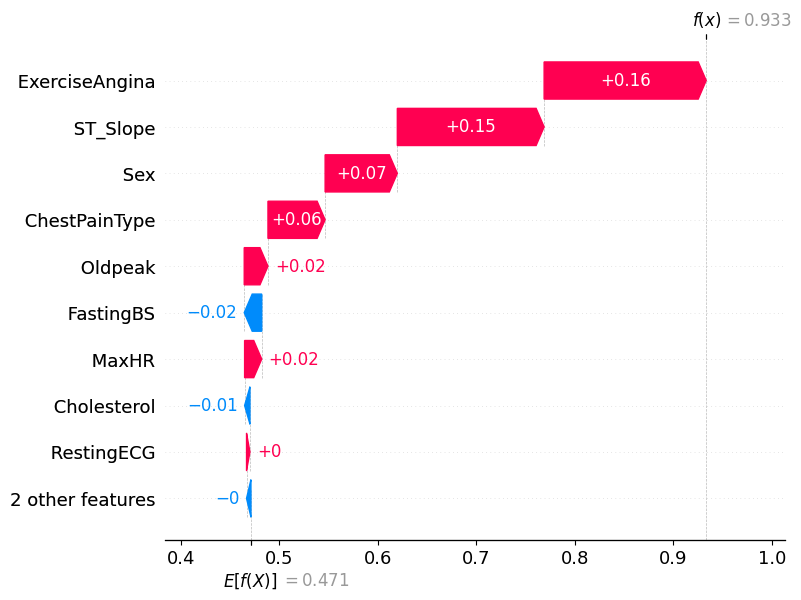

In [ ]:
shap.initjs()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_1[:, 0], X_te[1,:], feature_names = features)

Now lets try and see the explainations for a patient where the target value is 0: no heart disease and the model prediction was also 0:

In [ ]:
shap_values_0 = explainer.shap_values(X_te[150,:])

640/640 [==============================] - 2s 2ms/step


In [ ]:
shap_values_0.shape

(11, 1)

Lets see what the model predicts:

In [ ]:
model.predict(X_te)[150,:]

6/6 [==============================] - 0s 5ms/step


array([0.05194689], dtype=float32)

The Model is 5% sure that it is a heart disease or in othe words, ~95% sure that it is not a heart disease. We can check in the target variables set and see that the model is correct:

In [ ]:
yte[150]

0

In [ ]:
#converting back the standard-scaled feature back to its original values
standard_scaled_values = X_te[150, :]

# Get the mean and standard deviation used during the fit
mean = scaler.mean_
scale = scaler.scale_

# Reverse the standard scaling
original_values = standard_scaled_values * scale + mean

print(original_values)

[ 41.   1.   1. 120. 295.   0.   1. 170.   0.   0.   2.]


Lets have a look at the health data for this single patient:

**Observation:**

We can see that this patient is 41 years, male, chestpain type = atypical angina. The patient has a generally healthy upsloping ST_Slope (2), and has no exercise angina, meaning that he has NO pain in the chest that comes with exercise, stress, or other things that make the heart work harder, which is an extremely common symptom of coronary artery disease, which is caused by cholesterol-clogged coronary arteries.

The patient also has no concerning oldpeak has also no concerning fasting blood sugar.

In [ ]:


X.iloc[228,:]

Age                41.0
Sex                 1.0
ChestPainType       1.0
RestingBP         120.0
Cholesterol       295.0
FastingBS           0.0
RestingECG          1.0
MaxHR             170.0
ExerciseAngina      0.0
Oldpeak             0.0
ST_Slope            2.0
Name: 228, dtype: float64

The following can be interpreted: For this patient, the model predicts heart disease at a 5% chance. We can also clearly see which variables push down the result or influence the decision of the model to these 5%.

Again, this is because we are looking from the perspective of heart disease. In general, this means that the patient has no heart disease (threshold 0.5).

In this case, the healthy ST-Slope has the most impact on the decision, followed by the fact that the patient has NO excercise angina, a healthy or unconcerning oldpeak and is also relatively young (41 years old). Also the unconcerning fasting blood sugar as well as the type of chestpain he has and the maximum heart reate are pushing the model's decision against the prediction of heart disease.


On the other hand, we also see some features of this patient pushing the model towards a prediction for a heart disease, such as the fact that the patient is male, the not so good cholesterol levels as well as his Restin blood preassure.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_0[:, 0], X_te[150,:], feature_names = features)

Waterfall diagram for a more comprehensible view:

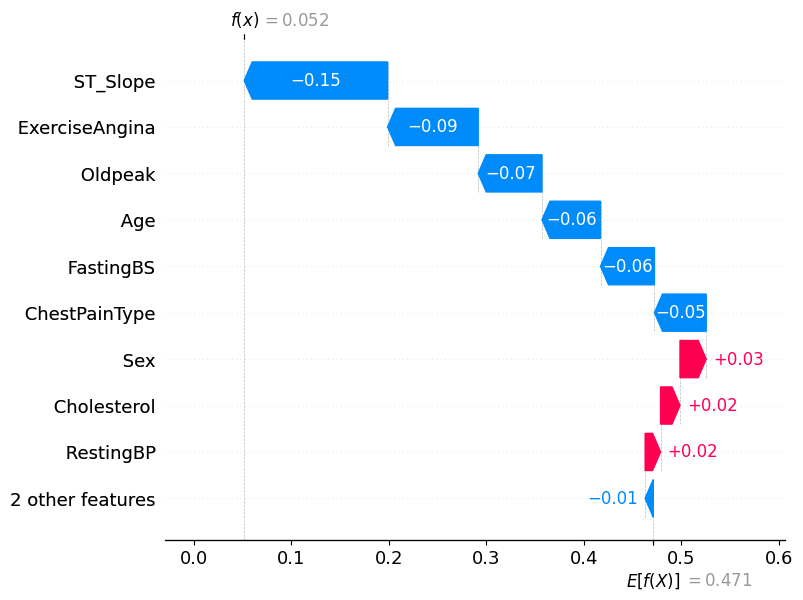

In [ ]:
shap.initjs()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_0[:, 0], X_te[150,:], feature_names = features)

## 4 Qualitative Analysis and Results

### RQ1: What are the key differences in the interpretability of machine learning models between image classification and tabular data analysis when utilizing SHAP explanations?

Key Differences in the Interpretability of Machine Learning Models Between Image Classification and Tabular Data Analysis Using SHAP Explanations:

**Local vs. Global Interpretability:**
- **Image Classification:** SHAP explanation can only be used locally as each image is different, providing insights on a per-image basis. Each explanation is specific to the image being analyzed, highlighting which pixels contributed most to the model's prediction.
- **Tabular Data Analysis:** SHAP can be used both locally and globally. Locally, it explains individual predictions by identifying important features for a specific instance. Globally, it can aggregate explanations to understand overall feature importance across the entire dataset.

**Data Characteristics:**
- **Image Data:** The underlying data consists of pixels, which are spatially structured and often contain complex patterns that the model must learn to recognize.
- **Tabular Data:** The data consists of features that can vary widely in type and scale. Features are typically independent of each other, and their relationships are not as visually intuitive as pixel arrangements.

**Interpretation:**
- **Image Data:** SHAP explanations for very are highly intuitive, as highlighted regions can be directly visualized, making it easy to see what parts of the image influenced the model's decision.
- **Tabular Data:** Interpreting SHAP explanations for tabular data often requires more domain knowledge. Understanding the impact of different features on the model's predictions involves comprehending the underlying data and the context of the features.




### RQ2: How does SHAP reveal the importance of different regions or structures within MRI brain scans in the decision-making process of machine learning models for brain tumor detection?

The SHAP explanations have proven to be a powerful tool for interpreting image data from MRI brain scans, despite challenges such as variations in imaging angles. Particularly, when the tumor region is distinctly visible, SHAP explanations consistently deliver interpretable results and provide valuable insights into the model's decision-making process.

- The model effectively differentiates between four classes of brain tumors.
- The SHAP explanations can accurately reveal the tumor regions within the MRI brain scans by visualizing the model's decision-making. 
- SHAP analyses also highlighted regions not readily apparent to non-specialists, which can also assist medical professionals in tumor detection.
- Removing the "notumor" class did not improve model performance.
- SHAP explanations enhance interpretability but do not always align with model accuracy, sometimes highlighting incorrect regions.
- Binary classification did not yield optimal SHAP results for distinguishing unhealthy regions despite accurate predictions, indicating complexity in interpreting SHAP for binary health assessments.


### RQ3: How does SHAP analysis reveal the importance of various clinical and demographic features in the prediction of heart failure using machine learning models? 

- The simple ANN, which we build ourselves with 1 hidden layer, can determine whether a patient has heart disease with 89% accuracy based on the 11 characteristics (risk factors) present in the dataset for each patient.
- The global SHAP explanations show which features or risk factors have the highest influence (positive and negative) on the model predictions generalized across all observations. The ranking of the features based on their influence is also very reasonable, considering that the most influential is the ST-Slope which describes a part of the heartbeat curve measured in an ECG, and Excercise Angina in 2nd place, which describes chest pain occurring during exercise or stress followed by sex, chestpain type, fasting blood sugar oldpeak, and age.
- The reason why cholesterol does not have such a high general impact might be because for 172 observations the cholesterol levels in the dataset were 0, and have been imputed with the mean value of all available cholesterol levels in the dataset. However, when SHAP is applied locally to patients for whom this value was not imputed, the SHAP explanations indeed show that cholesterol can have a high impact on the model decision if the cholesterol value deviates strongly from the imputed mean value.
- Locally applied on single patients (observations), the shap explanations reveal to what extent which features, given the feature values, contribute to the model prediction (probability value) for a respective patient. For a given patient, they show to what extent which features "push" towards a higher prediction for a heart disease and which push against a higher, towards a lower probability value for a heart disease, based on the feature values for that particular patient.
- Locally applied, for very clear predictions, the shap explanations are well reasonable and clear to interpret. However, for model prediction probabilities close to 0.5, the explanations become less clear and comprehensible, reflecting the need for human oversight by medical professionals.
- Nevertheless, given the model's recall score of 0.89, healthcare professionals should always review or cross-check each individual prediction/decision of the model for each patient, as there is still the possibility of false negative predictions.

# 5. Summary

The model to classify tumors performed very well, demonstrating high accuracy in its predictions. SHAP explanations are instrumental in understanding the model's decisions by highlighting the important regions of the brain. SHAP not only reveals that the model can identify the correct regions of the brain but also uncovers instances where the model learns patterns that allow it to make correct predictions without actually identifying the correct regions of the brain. SHAP explainations have also proven to be powerful for the interpretation of model decisions on tabular data, such as in this case of patient data including 11 features for predicting a heart disease. In the context of tabular data, SHAP not only provides local explanations for model decisions for a single patient (observation) but, in this case, can also be used for global (general) explanations for model decisions across the entire data set.


All in all, SHAP brings much-needed explainability into the decision-making process. This transparency is of utmost importance, as unexplainable decisions are not useful in real-life medical scenarios. Ensuring that medical professionals can trust and understand AI-driven diagnoses is crucial for safe and effective patient care.

# 6. References

Brain Tumor MRI dataset. (2021, September 24). Kaggle. https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Chander, A., Wang, J., Srinivasan, R., Uchino, K., & Chelian, S. (2018). Working with Beliefs: AI Transparency in the Enterprise [Journal-article]. http://ceur-ws.org/Vol-2068/exss14.pdf

Heart Failure Prediction Dataset. (2021, September 10). Kaggle. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

Holzinger, A., Biemann, C., Pattichis, C. S., & Kell, D. B. (2017). What do we need to build explainable AI systems for the medical domain? arXiv (Cornell University). https://doi.org/10.48550/arxiv.1712.09923            

Knapič, S., Malhi, A., Saluja, R., & Främling, K. (2021). Explainable artificial intelligence for human decision support system in the medical domain. Machine Learning and Knowledge Extraction, 3(3), 740–770. https://doi.org/10.3390/make3030037             

Meske, C., & Bunde, E. (2020). Transparency and Trust in Human-AI-Interaction: The role of Model-Agnostic Explanations in Computer Vision-Based Decision Support. In Lecture notes in computer science (pp. 54–69). https://doi.org/10.1007/978-3-030-50334-5_4      

Murel Jacob, & Kavlakoglu, E. (2024, February 12). What is transfer learning? | IBM. IBM. https://www.ibm.com/topics/transfer-learning 

Salehi, A. W., Khan, S., Gupta, G., Alabduallah, B. I., Almjally, A., Alsolai, H., Siddiqui, T., & Mellit, A. (2023). A study of CNN and transfer learning in Medical imaging: Advantages, challenges, future scope. Sustainability, 15(7), 5930. https://doi.org/10.3390/su15075930 

Voigt, P., & Von Dem Bussche, A. (2017). The EU General Data Protection Regulation (GDPR). In Springer eBooks. https://doi.org/10.1007/978-3-319-57959-7  

Welcome to the SHAP documentation — SHAP latest documentation. (n.d.). https://shap.readthedocs.io/en/latest/index.html